# Statistical Estimation for Physics

- Lecture on **Bayesian statistical inference**


Boris Bolliet (DAMTP)


From previous lectures:

- Bayes' theorem
- Central limit theorem 
- Estimators, bias, moments, least squares, maximum likelihood


In this lecture: 

- Bayes' theorem for statistical inference
- Concept of posterior, prior and likelihood 
- An illustrative example for parameter estimation


Next lecture:

- Bayesian model Selection
- Sampling


References for this lecture: 

- F. James, *Statistical Methods in Experimental Physics*, 2nd edition
- A. Heavens, *ICIC Data Analysis Workshop*
- R. Trotta, *Bayesian Methods in Cosmology* 
- S. Dodelson and F. Schmidt, *Modern Cosmology* 
- G. Cowan, *Statistical Data Analysis*, 1998
- D. Hogg, J. Bovy \& D. Lang, *Data analysis recipes: Fitting a model to data* 
- E. T. Jaynes, *Probability Theory, The Logic of Science*
- Hobson et al, *Bayesian Methods in Cosmology*
- T. Loredo, [BIPS](http://hosting.astro.cornell.edu/~loredo/bayes/index.html#gentxt)

# Motivations

Bayesian Statistical Inference (or, Bayesian Inference) is an answer to the **Inverse Problem**: *Given some data, what is the best model I can make to describe it*? 

This is a difficult problem, much more difficult than the converse. Once I have a model at hand, it is indeed easy to predict/compute what I data I expect to observe. 

# Bayes' theorem

## A conventional use example 

see https://kmh-lanl.hansonhub.com/course/yr2.pdf for $\mu$ and $\pi$ example.



## Bayes' theorem for inference

Let us call $D = \{d_1,..,d_n\}$ our vector of $n$ observations 


Bayes' theorem:

\begin{equation}
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
\end{equation}


Bayes' theorem for inference:


\begin{equation}
A = B
\end{equation}

# Importance of the Central Limit Theorem

The CLT is important to justify why we can almost always assume that the distribution followed by the measured values around their average is approximately normal. 

The random experimental error $e$ (which causes fluctuations of the measured values around the true and unknown value of the physical quantity) can be seen as an incoherent sum of smaller errors $e_i$'s) each contribution having a distribution that satisfies the condition sof the CLT. 

# Bayesian inference

Dependence of the final probabilities on the initial ones gets weaker as the amount of experimental information increases

# Bayesian inference of normally distributed observable

We can recover the inverse variance weighted result from the ML method. see section 5.4 of hansonhubyr2.pdf

# Bayesian inference and maximum likelihood

A maximum likelihood analysis and a Bayesian analysis using a flat prior are equivalent. 

In both ML and BI, the data $D$ and the parameters $\theta$ are both treated as random variables. 

Knowledge about $\theta$ is summarized by a probability density function (i.e., expresses the degree of belief for a parameter to take a given value). 

What we would like is the conditional pdf for $\theta$ given the data: $p(\theta|D)$.

We can express $p(\theta|D)$ using Bayes' theorem and the likelihood function. 


The likelihoood function is the joint pdf of the data, for a given parameter value $\theta$:

$$
L(D|\theta) = \prod_{i=1}^{n}f(d_i;\theta)
$$

Bayes' theorem states that

$$
p(\theta|D) = \frac{L(D|\theta)\pi(\theta)}{p(D)}
$$

# The likelihood 

The likelihood $\mathcal{L}(\theta) = L(D|\theta)$

# Bayesian versus frequentists

The likelihood (after proper normalization) has a probabilistic meaning for Bayesians, but not for frequentists. The Bayesians says that the probability that $\theta$ is in a certain interval is for example $68\%$. A frequentist won't say that, because the true value is a constant from their point of view. 

# Priors

A crucial advantage of Bayesian inference (which in some ways defines it) is that prior knowledge on the model can easily be incorporated. 

example of limits near a physical boundary (plots from Cowan)


Cowan also has a good discussion on constant prior and ML vs Bayesian estimator. 

- The Maxiumum Entropy Principle (or the Indifference Principle)


Problems: a transformation from one set of variables to another is non-linear, then what is uniform in one variable may not be uniform in the other. Exemple: $Y=X^2$.

Rule of thumb: use a uniform prior on the valiable that seems most appropriate to the problem. 


An illustrative example: **Bertrand's paradox of angels's sex**. Given a circle of radius $R$ and a chord drawn randomly on it, what is the probability that the length $L$ of the chord is smaller than $R$?

(see hansonhubyr2.pdf))



## Jeffrey's prior 

(Jeffrey 1948) In case where $\theta>0$ but no other prior information, one should use (Cowan p138)

$$
\pi(\theta) =
$$

# Illustrative example

In [74]:
import pyactlike
from getdist import loadMCSamples, MCSamples
from getdist import plots
import os
import yaml
import subprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
root_path = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks'

os.chdir(root_path)
try:
    os.mkdir("chains")
except FileExistsError:
    print(">> chain directory already exists")
path_to_chains_dir = root_path + '/chains/'

print(path_to_chains_dir)

>> chain directory already exists
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/


## Nuisance parameter

In [76]:
Dict_yaml = yaml.safe_load(open(path_to_chains_dir+'../mcmcs/cobaya/input_files/pyactlike_age_only_EE.yaml'))
Dict_yaml

{'output': 'plikHMTTTEE',
 'likelihood': {'pyactlike.ACTPol_lite_DR4_onlyEE': {'stop_at_error': True}},
 'theory': None,
 'params': {'logA': {'latex': 'ln10^{10}A_s', 'value': 3.0460125},
  'n_s': {'value': 1.0107972},
  'omega_b': {'value': 0.021519356},
  'omega_cdm': {'value': 0.11681165},
  'tau_reio': {'value': 0.063418096},
  'age': {'prior': {'min': 13.5, 'max': 14.5},
   'ref': {'dist': 'norm', 'loc': 13.8, 'scale': 0.1},
   'proposal': 0.1,
   'latex': 'age'},
  'yp2': {'prior': {'min': 0.9, 'max': 1.1},
   'ref': {'dist': 'norm', 'loc': 1.01, 'scale': 0.005}},
  'H0': {'derived': True}},
 'sampler': {'mcmc': {'covmat': 'CLASS2p8_ACTPol_lite_DR4_leakfix_yp2_baseLCDM_taup_hip_R0p01.covmat',
   'Rminus1_stop': 0.01,
   'proposal_scale': 1.9,
   'burn_in': 50,
   'max_tries': 5000,
   'learn_proposal': True,
   'learn_proposal_Rminus1_max': 30.0,
   'learn_proposal_Rminus1_max_early': 80.0}}}

In [90]:
Dict_yaml['output'] = path_to_chains_dir +'pyactlike_age_only'
Dict_yaml['sampler']['mcmc']['covmat'] = path_to_chains_dir+'../mcmcs/cobaya/covmats/pyactlike_age_only.covmat'
Dict_yaml['sampler']['mcmc']['Rminus1_stop'] = 0.01


Dict_yaml['theory'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['use_class_sz_fast_mode'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['stop_at_error'] = True
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['output'] = 'tCl'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_background_and_thermo'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pkl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pknl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_hubble'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_and_der'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_at_z'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_chi'] = 1 # for this run we dont need this
# settings for 1 massive neutrino and 2 massless states
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['cosmo_model'] = 0
# Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ncdm'] = 1
# Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ur']  = 2.0308

with open(path_to_chains_dir+'pyactlike_system.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

In [91]:
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      path_to_chains_dir+'pyactlike_system.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)

[0 : output] Output to be read-from/written-into folder '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains', with prefix 'pyactlike_age_only'
[0 : output] Found existing info files with the requested output prefix: '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_only'
[0 : output] Will delete previous products ('force' was requested).
[0 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[3 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[2 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.

2023-11-19 16:10:54.781497: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-19 16:10:54.781523: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 16:10:54.781526: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 16:10:54.781473: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-19 16:10:54.781506: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 16:10:54.781509: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 16:10:54.781593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-19 16:10:54.781599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU 

[0 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[1 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[2 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[3 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[0 : classy_szfast.classy_sz.classy_sz] Initialized!
[1 : classy_szfast.classy_sz.classy_sz] Initialized!
[2 : c

0

In [92]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'pyactlike_age_only')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.2"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

i=0
readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.3})
# p = readsamps.getParams()
# print('adding derived parameters')
# p = readsamps.getParams()
# readsamps.addDerived((p.H0/100.)**-2.*(p.omega_b+p.omega_cdm),name='Ombc',label=r'\Omega_{bc}')
Fs = readsamps.getInlineLatex('H0',limit=1)
print('H0: ',Fs)
Fs = readsamps.getInlineLatex('age',limit=1)
print('age: ',Fs)
# Fs = readsamps.getInlineLatex('m_ncdm',limit=2)
# print('m_ncdm: ',Fs)
samples = readsamps
samples.updateBaseStatistics()
all_samples.append(samples)

running getdist on chains /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_only


producing files in directory  ./
Removed 0.2 as burn in
using 2629 rows, 5 parameters; mean weight 1.288702928870293, tot weight 3388.0
Approx indep samples (N/corr length): 306
Equiv number of single samples (sum w)/max(w): 484
Effective number of weighted samples (sum w)^2/sum(w^2): 2154
Best fit sample -log(Like) = 47.343188
Ln(mean 1/like) = 49.656961
mean(-Ln(like)) = 48.291523
-Ln(mean like)  = 48.002984


producing files in directory  ./
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_only.4.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_only.3.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_only.2.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_only.1.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00980
RL: Thin for Markov:  7
RL: Thin for indep samples:   7
RL: Estimated burn in steps:  40  ( 31  rows)
using 2629 rows, 5 parameters; mean weight 1.288702928870293, tot weight 3388.0
Approx indep samples (N/corr length): 306
Equiv number of single samples (sum w)/max(w): 484
Effective number of weighted samples (sum w)^2/sum(w^2): 2154
Best fit sample -log(Like) = 47.343188
Ln(mean 1/like) = 49.656961
mean(-Ln(like)) = 48.291523
-Ln(mean like)  = 48.0

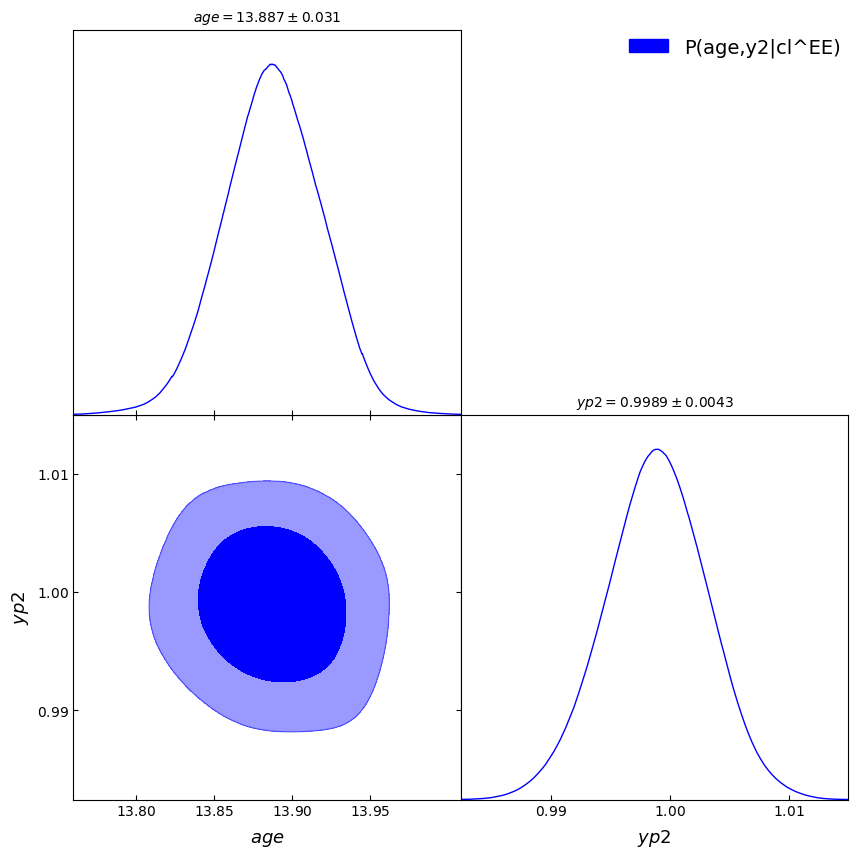

In [93]:
g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 10

g.settings.axes_fontsize = 10
g.settings.lab_fontsize =13

g.settings.legend_fontsize = 14
g.settings.alpha_filled_add=0.1
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False

g.settings.title_limit=1 #uncomment if you want to display marg stats.

sample_list = []
for s in range(len(all_samples)):

    sample_list.append(all_samples[s])
    
g.triangle_plot(sample_list,
    [
    # 'H0',
    'age',
    # 'm_ncdm',
    'yp2',
    ],

    filled=[True,False],
    legend_labels=[ 'P(age,y2|cl^EE)'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'1','color':'blue'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}]
                   )


# Main result

In [99]:
Dict_yaml = yaml.safe_load(open(path_to_chains_dir+'../mcmcs/cobaya/input_files/pyactlike_age_H0_derived.yaml'))
Dict_yaml

{'output': 'plikHMTTTEE',
 'likelihood': {'pyactlike.ACTPol_lite_DR4_onlyTT': {'stop_at_error': True}},
 'theory': None,
 'params': {'logA': {'latex': 'ln10^{10}A_s', 'value': 3.0460125},
  'n_s': {'value': 1.0107972},
  'omega_b': {'value': 0.021519356},
  'omega_cdm': {'value': 0.11681165},
  'tau_reio': {'value': 0.063418096},
  'age': {'prior': {'min': 13.5, 'max': 14.5},
   'ref': {'dist': 'norm', 'loc': 13.8, 'scale': 0.1},
   'proposal': 0.1,
   'latex': 'age'},
  'm_ncdm': {'prior': {'min': 0.06, 'max': 2.0},
   'ref': {'dist': 'norm', 'loc': 0.007914083, 'scale': 0.1502374},
   'proposal': 0.1502374,
   'latex': 'm_\\mathrm{ncdm}'},
  'yp2': {'value': 1.0},
  'H0': {'derived': True}},
 'sampler': {'mcmc': {'covmat': 'CLASS2p8_ACTPol_lite_DR4_leakfix_yp2_baseLCDM_taup_hip_R0p01.covmat',
   'Rminus1_stop': 0.01,
   'proposal_scale': 1.9,
   'burn_in': 50,
   'max_tries': 5000,
   'learn_proposal': True,
   'learn_proposal_Rminus1_max': 30.0,
   'learn_proposal_Rminus1_max_early'

In [100]:
Dict_yaml['output'] = path_to_chains_dir +'pyactlike_age'
Dict_yaml['sampler']['mcmc']['covmat'] = path_to_chains_dir+'../mcmcs/cobaya/covmats/pyactlike_age_mnu.covmat'
Dict_yaml['sampler']['mcmc']['Rminus1_stop'] = 0.01


Dict_yaml['theory'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['use_class_sz_fast_mode'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['stop_at_error'] = True
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['output'] = 'tCl'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_background_and_thermo'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pkl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pknl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_hubble'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_and_der'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_at_z'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_chi'] = 1 # for this run we dont need this
# settings for 1 massive neutrino and 2 massless states
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['cosmo_model'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ncdm'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ur']  = 2.0308

with open(path_to_chains_dir+'pyactlike_system.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

## run the chains

In [101]:
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      path_to_chains_dir+'pyactlike_system.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)

[0 : output] Output to be read-from/written-into folder '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains', with prefix 'pyactlike_age'
[0 : output] Found existing info files with the requested output prefix: '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age'
[0 : output] Will delete previous products ('force' was requested).
[0 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[2 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[1 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[3 

2023-11-19 16:16:39.056959: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-19 16:16:39.056989: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 16:16:39.056992: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 16:16:39.056981: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-19 16:16:39.057003: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 16:16:39.057006: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 16:16:39.057055: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-19 16:16:39.057077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/rep

[0 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[1 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[3 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[2 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[2 : classy_szfast.classy_sz.classy_sz] Initialized!
[0 : classy_szfast.classy_sz.classy_sz] Initialized!
[1 : c

0

In [755]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'pyactlike_age')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.2"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

i=0
readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.3})
# p = readsamps.getParams()
# print('adding derived parameters')
# p = readsamps.getParams()
# readsamps.addDerived((p.H0/100.)**-2.*(p.omega_b+p.omega_cdm),name='Ombc',label=r'\Omega_{bc}')
Fs = readsamps.getInlineLatex('H0',limit=1)
print('H0: ',Fs)
Fs = readsamps.getInlineLatex('age',limit=1)
print('age: ',Fs)
Fs = readsamps.getInlineLatex('m_ncdm',limit=2)
print('m_ncdm: ',Fs)
readsamps.paramNames.parWithName('m_ncdm').label = r'M_\nu\,\,\mathrm{[eV]}'
readsamps.paramNames.parWithName('age').label = r'\mathrm{age}\,\,\mathrm{[Gyr]}'
samples = readsamps
samples.updateBaseStatistics()
all_samples.append(samples)

running getdist on chains /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age


producing files in directory  ./
Removed 0.2 as burn in
using 3738 rows, 5 parameters; mean weight 3.118780096308186, tot weight 11658.0
Approx indep samples (N/corr length): 1179
Equiv number of single samples (sum w)/max(w): 507
Effective number of weighted samples (sum w)^2/sum(w^2): 2151
Best fit sample -log(Like) = 49.454715
Ln(mean 1/like) = 51.108216
mean(-Ln(like)) = 50.313500
-Ln(mean like)  = 50.064571


producing files in directory  ./
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age.3.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age.2.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age.1.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age.4.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00337
RL: Not enough samples to estimate convergence stats
using 3738 rows, 5 parameters; mean weight 3.118780096308186, tot weight 11658.0
Approx indep samples (N/corr length): 1179
Equiv number of single samples (sum w)/max(w): 507
Effective number of weighted samples (sum w)^2/sum(w^2): 2151
Best fit sample -log(Like) = 49.454715
Ln(mean 1/like) = 51.108216
mean(-Ln(like)) = 50.313500
-Ln(mean like)  = 50.064571
H0:  H0 = 64.0^{+2.3}_{-2.0}
age:  age = 14.05^{+0.11}_{-0.09

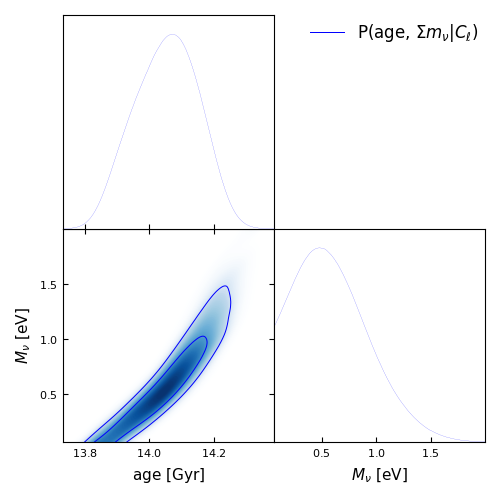

In [747]:
g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 5

g.settings.axes_fontsize = 10
g.settings.lab_fontsize =13

g.settings.legend_fontsize = 14
g.settings.alpha_filled_add=0.1
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False
g.settings.num_plot_contours = 2
g.settings.title_limit=0 #uncomment if you want to display marg stats.

sample_list = []
for s in range(len(all_samples)):

    sample_list.append(all_samples[s])
    
g.triangle_plot(sample_list,
    [
    # 'H0',
    'age',
    'm_ncdm',
    # 'yp2',
    ],

    filled=[False,False],
    shaded=True,
    legend_labels=[ r'P(age, $\Sigma m_\nu$|$C_\ell$)'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'0.1','color':'blue','ls':'-'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}]
                   )

g.export(path_to_chains_dir +'actlite_TT_age_mnu.pdf')


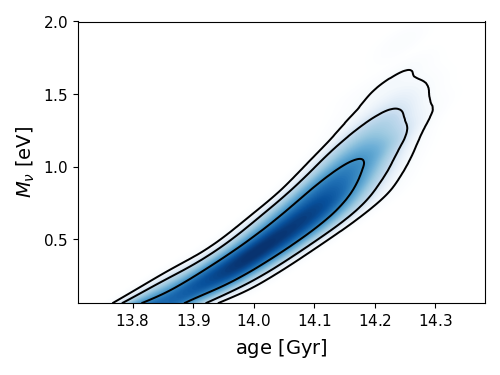

In [756]:
g = plots.get_single_plotter(width_inch=5)

g.settings.num_plot_contours = 10
g.plot_2d([sample_list[0]], 'age', 'm_ncdm', shaded=True,
          ls='None',
         );

# g.export(path_to_chains_dir +'actlite_TT_age_mnu_2d_shaded.png')
plt.savefig('actlite_TT_age_mnu_2d_shaded.png',dpi=300)

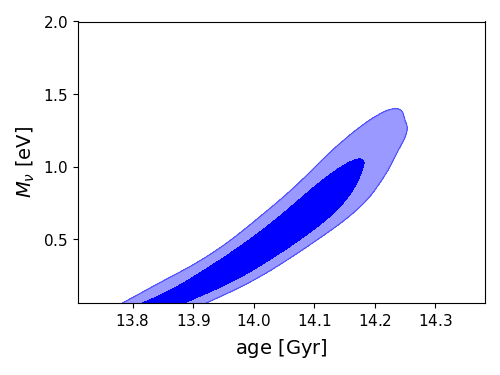

In [757]:
g = plots.get_single_plotter(width_inch=5)

g.settings.num_plot_contours = 2
g.plot_2d([sample_list[0]], 'age', 'm_ncdm', shaded=False,filled=True,
          ls='None',colors=['blue']
         );

# g.export(path_to_chains_dir +'actlite_TT_age_mnu_2d_shaded.png')
plt.savefig('actlite_TT_age_mnu_2d_1_2s.png',dpi=300)

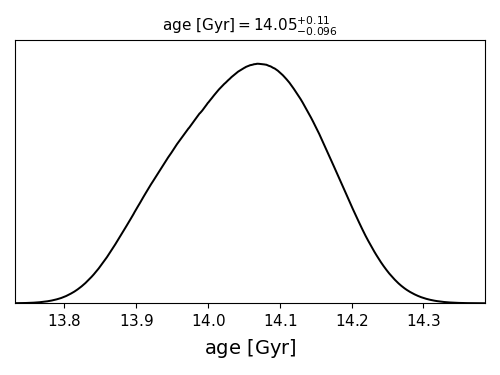

In [751]:
g = plots.get_single_plotter(width_inch=5)
g.settings.title_limit=1
g.plot_1d([sample_list[0]], 'age', shaded=True);
ax = g.subplots[0,0]
# ax.axhline(1.03, color='gray', ls='--')

# g.export(path_to_chains_dir +'actlite_TT_age_1d.pdf')
plt.savefig('actlite_TT_age_mnu_1d.png',dpi=300)

In [40]:
g.subplots

array([[<AxesSubplot: title={'center': '$\\mathrm{age}\\,\\,\\mathrm{[Gyr]} = 14.05^{+0.11}_{-0.096}$'}, xlabel='$\\mathrm{age}\\,\\,\\mathrm{[Gyr]}$'>]],
      dtype=object)

## Uniform prior in logMnu

the minimal neutrino mass

In [12]:
np.log(0.06)

-2.8134107167600364

In [13]:
np.log(2.)

0.6931471805599453

In [109]:
Dict_yaml = yaml.safe_load(open(path_to_chains_dir+'../mcmcs/cobaya/input_files/pyactlike_age_logmnu_H0_derived.yaml'))
Dict_yaml

{'output': 'plikHMTTTEE',
 'likelihood': {'pyactlike.ACTPol_lite_DR4_onlyTT': {'stop_at_error': True}},
 'theory': None,
 'params': {'logA': {'latex': 'ln10^{10}A_s', 'value': 3.0460125},
  'n_s': {'value': 1.0107972},
  'omega_b': {'value': 0.021519356},
  'omega_cdm': {'value': 0.11681165},
  'tau_reio': {'value': 0.063418096},
  'age': {'prior': {'min': 13.7, 'max': 14.3},
   'ref': {'dist': 'norm', 'loc': 13.8, 'scale': 0.1},
   'proposal': 0.1,
   'latex': 'age'},
  'logm_ncdm': {'prior': {'min': -2.81341, 'max': 0.693},
   'ref': {'dist': 'norm', 'loc': 0.0, 'scale': 0.1502374},
   'proposal': 0.1502374,
   'latex': 'log m_\\mathrm{ncdm}',
   'drop': True},
  'm_ncdm': 'lambda logm_ncdm: np.exp(logm_ncdm)',
  'yp2': {'value': 1.0},
  'H0': {'derived': True}},
 'sampler': {'mcmc': {'covmat': 'CLASS2p8_ACTPol_lite_DR4_leakfix_yp2_baseLCDM_taup_hip_R0p01.covmat',
   'Rminus1_stop': 0.01,
   'proposal_scale': 1.9,
   'burn_in': 50,
   'max_tries': 5000,
   'learn_proposal': True,
   

In [110]:
Dict_yaml['output'] = path_to_chains_dir +'pyactlike_logmnu'
Dict_yaml['sampler']['mcmc']['covmat'] = path_to_chains_dir+'../mcmcs/cobaya/covmats/chains/pyactlike_logmnu.covmat'
Dict_yaml['sampler']['mcmc']['Rminus1_stop'] = 0.01

Dict_yaml['theory'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['use_class_sz_fast_mode'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['stop_at_error'] = True
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['output'] = 'tCl'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_background_and_thermo'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pkl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pknl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_hubble'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_and_der'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_at_z'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_chi'] = 1 # for this run we dont need this
# settings for 1 massive neutrino and 2 massless states
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['cosmo_model'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ncdm'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ur']  = 2.0308



with open(path_to_chains_dir+'pyactlike_system_logmnu.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

In [111]:
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      path_to_chains_dir+'pyactlike_system_logmnu.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)

[0 : output] Output to be read-from/written-into folder '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains', with prefix 'pyactlike_logmnu'
[0 : output] Found existing info files with the requested output prefix: '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_logmnu'
[0 : output] Will delete previous products ('force' was requested).
[2 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[3 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[0 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam

2023-11-19 16:28:41.962461: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-19 16:28:41.962650: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 16:28:41.962689: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 16:28:41.962803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-19 16:28:41.962826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-19 16:28:41.962925: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-19 16:28:41.962953: I metal_plugin/src/device/metal_device.cc:29

[0 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[1 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[2 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[3 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[0 : classy_szfast.classy_sz.classy_sz] Initialized!
[1 : classy_szfast.classy_sz.classy_sz] Initialized!
[2 : c

KeyboardInterrupt: 

In [112]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'pyactlike')
path_to_chains.append(path_to_chains_dir)

final_chain_dir_list.append(path_to_chains_dir +'pyactlike_logmnu')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.2"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

for i in range(len(final_chain_dir_list)):
    readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.3})
    # p = readsamps.getParams()
    # print('adding derived parameters')
    # p = readsamps.getParams()
    # readsamps.addDerived((p.H0/100.)**-2.*(p.omega_b+p.omega_cdm),name='Ombc',label=r'\Omega_{bc}')
    Fs = readsamps.getInlineLatex('H0',limit=1)
    print('H0: ',Fs)
    Fs = readsamps.getInlineLatex('age',limit=1)
    print('age: ',Fs)
    Fs = readsamps.getInlineLatex('m_ncdm',limit=2)
    print('m_ncdm: ',Fs)
    samples = readsamps
    samples.updateBaseStatistics()
    all_samples.append(samples)

running getdist on chains /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike
producing files in directory  ./
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike.2.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike.3.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike.1.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike.4.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.01098
RL: Thin for Markov:  8
RL: Thin for indep samples:   17
RL: Estimated burn in steps:  112  ( 81  rows)
using 10163 rows, 6 parameters; mean weight 1.3870904260552985, tot weight 14097.0
Approx indep samples (N/corr length): 877
Equiv number of single samples (sum w)/max(w): 1762
Effective number of weighted samples (sum w)^2/sum(w^2): 7967
Best fit sample -log(Like) = 51.923325


producing files in directory  ./
Removed 0.2 as burn in
using 10163 rows, 6 parameters; mean weight 1.3870904260552985, tot weight 14097.0
Approx indep samples (N/corr length): 877
Equiv number of single samples (sum w)/max(w): 1762
Effective number of weighted samples (sum w)^2/sum(w^2): 7967
Best fit sample -log(Like) = 51.923325
Ln(mean 1/like) = 53.726528
mean(-Ln(like)) = 52.766979
-Ln(mean like)  = 52.528991


producing files in directory  ./
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_logmnu.4.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_logmnu.2.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_logmnu.3.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_logmnu.1.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00667
RL: Thin for Markov:  27
RL: Thin for indep samples:   27
RL: Estimated burn in steps:  92  ( 29  rows)
using 7058 rows, 6 parameters; mean weight 3.130773590252196, tot weight 22097.0
Approx indep samples (N/corr length): 2161
Equiv number of single samples (sum w)/max(w): 818
Effective number of weighted samples (sum w)^2/sum(w^2): 4128
Best fit sample -log(Like) = 49.535886
Ln(mean 1/like) = 50.982230
mean(-Ln(like)) = 50.302969
-Ln(mean like)  = 50.11508

producing files in directory  ./
Removed 0.2 as burn in
using 7058 rows, 6 parameters; mean weight 3.130773590252196, tot weight 22097.0
Approx indep samples (N/corr length): 2161
Equiv number of single samples (sum w)/max(w): 818
Effective number of weighted samples (sum w)^2/sum(w^2): 4128
Best fit sample -log(Like) = 49.535886
Ln(mean 1/like) = 50.982230
mean(-Ln(like)) = 50.302969
-Ln(mean like)  = 50.115082


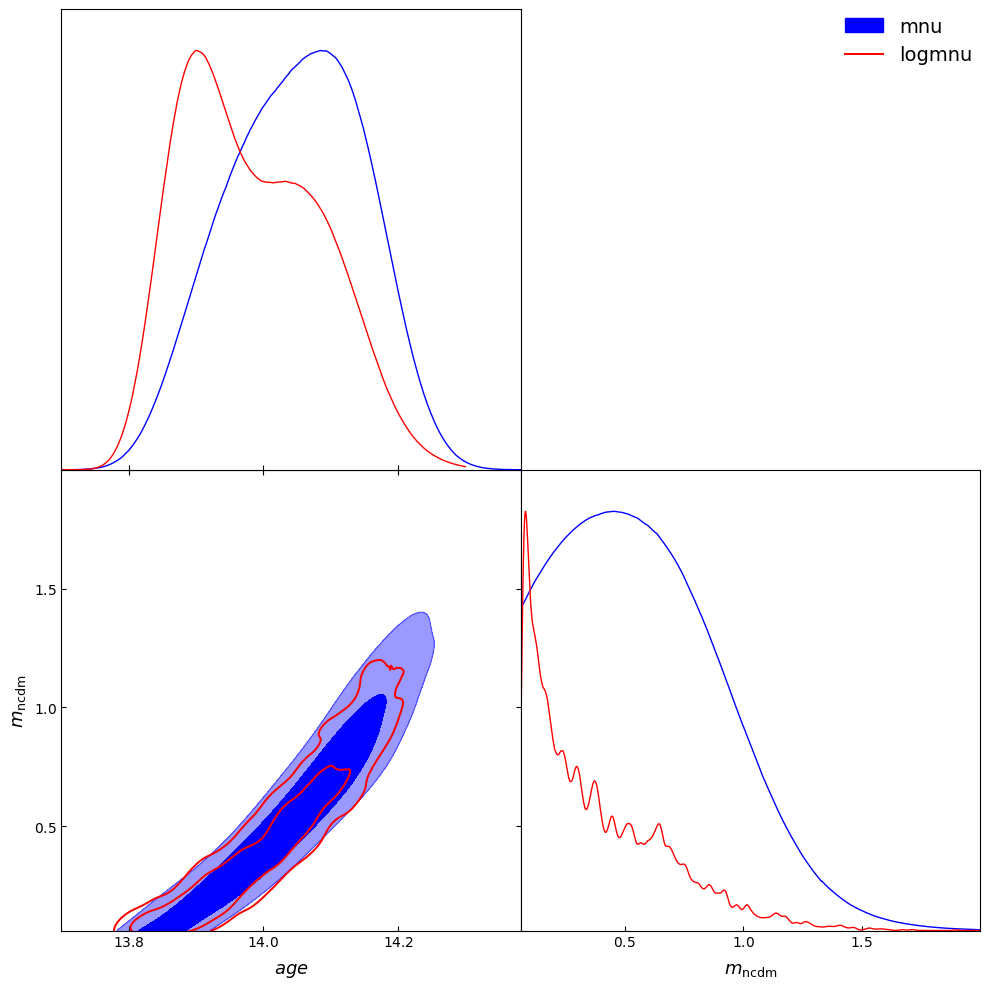

In [114]:
g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 10

g.settings.axes_fontsize = 10
g.settings.lab_fontsize =13

g.settings.legend_fontsize = 14
g.settings.alpha_filled_add=0.1
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False

g.settings.title_limit=0 #uncomment if you want to display marg stats.

sample_list = []
for s in range(len(all_samples)):

    sample_list.append(all_samples[s])
    
g.triangle_plot(sample_list,
    [
    # 'H0',
    'age',
    'm_ncdm',
    # 'yp2',
    ],

    filled=[True,False],
    legend_labels=[ 'mnu','logmnu'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'1','color':'blue'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}]
                   )

## Age measured

In [60]:
Dict_yaml = yaml.safe_load(open(path_to_chains_dir+'../mcmcs/cobaya/input_files/pyactlike_age_H0_derived_mnu_prior.yaml'))
Dict_yaml

{'output': 'plikHMTTTEE',
 'likelihood': {'pyactlike.ACTPol_lite_DR4_onlyTT': {'stop_at_error': True}},
 'theory': None,
 'params': {'logA': {'latex': 'ln10^{10}A_s', 'value': 3.0460125},
  'n_s': {'value': 1.0107972},
  'omega_b': {'value': 0.021519356},
  'omega_cdm': {'value': 0.11681165},
  'tau_reio': {'value': 0.063418096},
  'age': {'prior': {'min': 13.7, 'max': 14.3},
   'ref': {'dist': 'norm', 'loc': 13.8, 'scale': 0.1},
   'proposal': 0.1,
   'latex': 'age'},
  'm_ncdm': {'prior': {'min': 0.06, 'max': 2.0},
   'ref': {'dist': 'norm', 'loc': 0.007914083, 'scale': 0.1502374},
   'proposal': 0.1502374,
   'latex': 'm_\\mathrm{ncdm}'},
  'yp2': {'value': 1.0},
  'H0': {'derived': True}},
 'sampler': {'mcmc': {'covmat': 'CLASS2p8_ACTPol_lite_DR4_leakfix_yp2_baseLCDM_taup_hip_R0p01.covmat',
   'Rminus1_stop': 0.01,
   'proposal_scale': 1.9,
   'burn_in': 50,
   'max_tries': 5000,
   'learn_proposal': True,
   'learn_proposal_Rminus1_max': 30.0,
   'learn_proposal_Rminus1_max_early'

In [65]:
Dict_yaml['prior'] = {
    'age': 'lambda age:  stats.norm.logpdf(age, loc=14.005, scale=0.005)'
}

In [70]:
Dict_yaml['output'] = path_to_chains_dir +'pyactlike_age_age_prior'
Dict_yaml['sampler']['mcmc']['covmat'] = path_to_chains_dir+'../mcmcs/cobaya/covmats/pyactlike_age_mnu.covmat'
Dict_yaml['sampler']['mcmc']['Rminus1_stop'] = 0.01


Dict_yaml['theory'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['use_class_sz_fast_mode'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['stop_at_error'] = True
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['output'] = 'tCl'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_background_and_thermo'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pkl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pknl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_hubble'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_and_der'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_at_z'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_chi'] = 1 # for this run we dont need this
# settings for 1 massive neutrino and 2 massless states
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['cosmo_model'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ncdm'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ur']  = 2.0308

with open(path_to_chains_dir+'pyactlike_system.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

In [71]:
Dict_yaml

{'output': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_age_prior',
 'likelihood': {'pyactlike.ACTPol_lite_DR4_onlyTT': {'stop_at_error': True}},
 'theory': {'classy_szfast.classy_sz.classy_sz': {'use_class_sz_fast_mode': 1,
   'stop_at_error': True,
   'extra_args': {'output': 'tCl',
    'skip_background_and_thermo': 0,
    'skip_pkl': 1,
    'skip_pknl': 1,
    'skip_hubble': 1,
    'skip_sigma8_and_der': 1,
    'skip_sigma8_at_z': 1,
    'skip_chi': 1,
    'cosmo_model': 1,
    'N_ncdm': 1,
    'N_ur': 2.0308}}},
 'params': {'logA': {'latex': 'ln10^{10}A_s', 'value': 3.0460125},
  'n_s': {'value': 1.0107972},
  'omega_b': {'value': 0.021519356},
  'omega_cdm': {'value': 0.11681165},
  'tau_reio': {'value': 0.063418096},
  'age': {'prior': {'min': 13.7, 'max': 14.3},
   'ref': {'dist': 'norm', 'loc': 13.8, 'scale': 0.1},
   'proposal': 0.1,
   'latex': 'age'},
  'm_ncdm': {'prior': {'min': 0.06, 'max': 2.0},
   'ref': {'dist': 'norm', 'loc': 

In [72]:
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      path_to_chains_dir+'pyactlike_system.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)

[0 : output] Output to be read-from/written-into folder '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains', with prefix 'pyactlike_age_age_prior'
[0 : output] Found existing info files with the requested output prefix: '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_age_prior'
[0 : output] Will delete previous products ('force' was requested).
[1 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[2 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[0 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimize

2023-11-20 23:07:32.716837: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-20 23:07:32.716837: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-20 23:07:32.716871: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-20 23:07:32.716874: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-20 23:07:32.716838: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-20 23:07:32.716869: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-20 23:07:32.716873: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-20 23:07:32.716837: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-20 23:07:32.716868: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-20 23:07:32.716872: I metal_plugin/src/device/metal_device.cc:31

[0 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[1 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[2 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[3 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[0 : prior] *WARNING* External prior 'age' loaded. Mind that it might not be normalized!
[0 : classy_szfast.clas

0

In [88]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'pyactlike_age')
path_to_chains.append(path_to_chains_dir)

final_chain_dir_list.append(path_to_chains_dir +'pyactlike_age_age_prior')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.2"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

for i in range(len(final_chain_dir_list)):
    readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.3})
    # p = readsamps.getParams()
    # print('adding derived parameters')
    # p = readsamps.getParams()
    # readsamps.addDerived((p.H0/100.)**-2.*(p.omega_b+p.omega_cdm),name='Ombc',label=r'\Omega_{bc}')
    Fs = readsamps.getInlineLatex('H0',limit=1)
    print('H0: ',Fs)
    Fs = readsamps.getInlineLatex('age',limit=1)
    print('age: ',Fs)
    Fs = readsamps.getInlineLatex('m_ncdm',limit=2)
    print('m_ncdm: ',Fs)
    readsamps.paramNames.parWithName('m_ncdm').label = r'M_\nu\,\,\mathrm{[eV]}'
    readsamps.paramNames.parWithName('age').label = r'\mathrm{age}\,\,\mathrm{[Gyr]}'
    samples = readsamps
    samples.updateBaseStatistics()
    all_samples.append(samples)

running getdist on chains /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age
producing files in directory  ./
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age.3.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age.2.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age.1.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age.4.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00337
RL: Not enough samples to estimate convergence stats
using 3738 rows, 5 parameters; mean weight 3.118780096308186, tot weight 11658.0
Approx indep samples (N/corr length): 1179
Equiv number of single samples (sum w)/max(w): 507
Effective number of weighted samples (sum w)^2/sum(w^2): 2151
Best fit sample -log(Like) = 49.454715
Ln(mean 1/like) = 51.108216
mean(

producing files in directory  ./
Removed 0.2 as burn in
using 3738 rows, 5 parameters; mean weight 3.118780096308186, tot weight 11658.0
Approx indep samples (N/corr length): 1179
Equiv number of single samples (sum w)/max(w): 507
Effective number of weighted samples (sum w)^2/sum(w^2): 2151
Best fit sample -log(Like) = 49.454715
Ln(mean 1/like) = 51.108216
mean(-Ln(like)) = 50.313500
-Ln(mean like)  = 50.064571
producing files in directory  ./
Removed 0.2 as burn in
using 2743 rows, 7 parameters; mean weight 2.679912504557054, tot weight 7351.0
Approx indep samples (N/corr length): 945
Equiv number of single samples (sum w)/max(w): 408
Effective number of weighted samples (sum w)^2/sum(w^2): 1651
Best fit sample -log(Like) = 44.615748
Ln(mean 1/like) = 46.890145
mean(-Ln(like)) = 45.584813
-Ln(mean like)  = 45.291625


producing files in directory  ./
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_age_prior.4.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_age_prior.3.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_age_prior.2.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_age_prior.1.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00086
RL: Thin for Markov:  18
RL: Thin for indep samples:   18
RL: Estimated burn in steps:  54  ( 20  rows)
using 2743 rows, 7 parameters; mean weight 2.679912504557054, tot weight 7351.0
Approx indep samples (N/corr length): 945
Equiv number of single samples (sum w)/max(w): 408
Effective number of weighted samples (sum w)^2/sum(w^2): 1651
Best fit sample -log(Like) = 44.615748
Ln(mean 1/like) = 46.890145
mean(-Ln(like)) = 45.584813


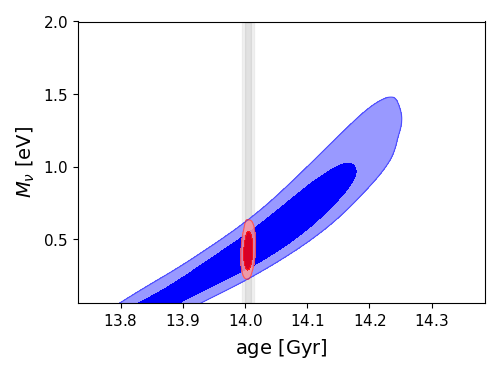

In [89]:
g = plots.get_single_plotter(width_inch=5)
g.add_x_bands(14.005, 0.005)
g.plot_2d([all_samples[0],
           all_samples[1]], 
          'age', 'm_ncdm', filled={True,True},colors=['blue','red']);

g.export(path_to_chains_dir +'actlite_TT_age_mnu_age_prior_2d.pdf')

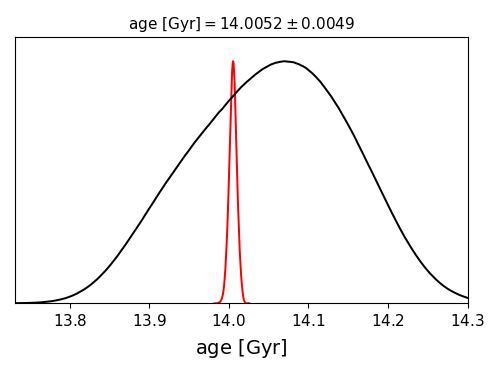

In [101]:
import scipy
g = plots.get_single_plotter(width_inch=5)
g.settings.title_limit=1
g.plot_1d([all_samples[1],all_samples[0]], 'age', shaded=True,colors=['red','black']);
ax = g.subplots[0,0]
# ax.axhline(1.03, color='gray', ls='--')
# mu = 14.005  # mean
# sigma = 0.005  # standard deviation
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)  # 100 points between (mean - 3*std) and (mean + 3*std)
# y = scipy.stats.norm.pdf(x, mu, sigma)  # Probability density function

# Plot the normal distribution
# ax.plot(x, y, label='Normal Distribution')

# ax.plot()
g.export(path_to_chains_dir +'actlite_TT_age_1d_age_prior.pdf')

## Assume a new particle physics experiment has measured the neutrino mass


we assume a new particle physics experiment has measured the masses of neutrinos, yielding:

\begin{equation}
\Sigma m_\nu = 0.15 \pm 0.05 \,\,\mathrm{eV}
\end{equation}

what is the age of the universe? 

In [115]:
Dict_yaml = yaml.safe_load(open(path_to_chains_dir+'../mcmcs/cobaya/input_files/pyactlike_age_H0_derived_mnu_prior.yaml'))
Dict_yaml

{'output': 'plikHMTTTEE',
 'likelihood': {'pyactlike.ACTPol_lite_DR4_onlyTT': {'stop_at_error': True}},
 'theory': None,
 'params': {'logA': {'latex': 'ln10^{10}A_s', 'value': 3.0460125},
  'n_s': {'value': 1.0107972},
  'omega_b': {'value': 0.021519356},
  'omega_cdm': {'value': 0.11681165},
  'tau_reio': {'value': 0.063418096},
  'age': {'prior': {'min': 13.7, 'max': 14.3},
   'ref': {'dist': 'norm', 'loc': 13.8, 'scale': 0.1},
   'proposal': 0.1,
   'latex': 'age'},
  'm_ncdm': {'prior': {'min': 0.06, 'max': 2.0},
   'ref': {'dist': 'norm', 'loc': 0.007914083, 'scale': 0.1502374},
   'proposal': 0.1502374,
   'latex': 'm_\\mathrm{ncdm}'},
  'yp2': {'value': 1.0},
  'H0': {'derived': True}},
 'sampler': {'mcmc': {'covmat': 'CLASS2p8_ACTPol_lite_DR4_leakfix_yp2_baseLCDM_taup_hip_R0p01.covmat',
   'Rminus1_stop': 0.01,
   'proposal_scale': 1.9,
   'burn_in': 50,
   'max_tries': 5000,
   'learn_proposal': True,
   'learn_proposal_Rminus1_max': 30.0,
   'learn_proposal_Rminus1_max_early'

In [116]:
Dict_yaml['output'] = path_to_chains_dir +'pyactlike_age_mnu_prior'
Dict_yaml['sampler']['mcmc']['covmat'] = path_to_chains_dir+'../mcmcs/cobaya/covmats/chains/pyactlike_age_mnu_prior.covmat'
Dict_yaml['sampler']['mcmc']['Rminus1_stop'] = 0.01


Dict_yaml['theory'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['use_class_sz_fast_mode'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['stop_at_error'] = True
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['output'] = 'tCl'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_background_and_thermo'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pkl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pknl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_hubble'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_and_der'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_at_z'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_chi'] = 1 # for this run we dont need this
# settings for 1 massive neutrino and 2 massless states
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['cosmo_model'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ncdm'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ur']  = 2.0308

with open(path_to_chains_dir+'pyactlike_system.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

### run the chains

In [117]:
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      path_to_chains_dir+'pyactlike_system.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)

[0 : output] Output to be read-from/written-into folder '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains', with prefix 'pyactlike_age_mnu_prior'
[0 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[1 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[3 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[2 : absl] *WARNING* At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
[1 : absl] *WARNING

2023-11-19 16:44:03.629893: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-19 16:44:03.629923: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 16:44:03.629927: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 16:44:03.629921: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-19 16:44:03.629948: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 16:44:03.629952: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 16:44:03.629986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-19 16:44:03.630008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/rep

[0 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[2 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[3 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[1 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[0 : prior] *WARNING* External prior 'mnu_prior' loaded. Mind that it might not be normalized!
[0 : classy_szfas

0

In [198]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'pyactlike')
path_to_chains.append(path_to_chains_dir)

final_chain_dir_list.append(path_to_chains_dir +'pyactlike_age_mnu_prior')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.2"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

for i in range(len(final_chain_dir_list)):
    readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.3})
    # p = readsamps.getParams()
    # print('adding derived parameters')
    # p = readsamps.getParams()
    # readsamps.addDerived((p.H0/100.)**-2.*(p.omega_b+p.omega_cdm),name='Ombc',label=r'\Omega_{bc}')
    Fs = readsamps.getInlineLatex('H0',limit=1)
    print('H0: ',Fs)
    Fs = readsamps.getInlineLatex('age',limit=1)
    print('age: ',Fs)
    Fs = readsamps.getInlineLatex('m_ncdm',limit=2)
    print('m_ncdm: ',Fs)
    readsamps.paramNames.parWithName('m_ncdm').label = r'M_\nu\,\,\mathrm{[eV]}'
    readsamps.paramNames.parWithName('age').label = r'\mathrm{age}\,\,\mathrm{[Gyr]}'
    samples = readsamps
    samples.updateBaseStatistics()
    all_samples.append(samples)

running getdist on chains /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike
producing files in directory  ./
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike.2.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike.3.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike.1.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike.4.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.01098
RL: Thin for Markov:  8
RL: Thin for indep samples:   17
RL: Estimated burn in steps:  112  ( 81  rows)
using 10163 rows, 6 parameters; mean weight 1.3870904260552985, tot weight 14097.0
Approx indep samples (N/corr length): 877
Equiv number of single samples (sum w)/max(w): 1762
Effective number of weighted samples (sum w)^2/sum(w^2): 7967
Best fit sample -log(Like) = 51.923325


producing files in directory  ./
Removed 0.2 as burn in
using 10163 rows, 6 parameters; mean weight 1.3870904260552985, tot weight 14097.0
Approx indep samples (N/corr length): 877
Equiv number of single samples (sum w)/max(w): 1762
Effective number of weighted samples (sum w)^2/sum(w^2): 7967
Best fit sample -log(Like) = 51.923325
Ln(mean 1/like) = 53.726528
mean(-Ln(like)) = 52.766979
-Ln(mean like)  = 52.528991


producing files in directory  ./
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_mnu_prior.4.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_mnu_prior.2.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_mnu_prior.3.txt
/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_organization/notebooks/chains/pyactlike_age_mnu_prior.1.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00470
RL: Thin for Markov:  19
RL: Thin for indep samples:   19
RL: Estimated burn in steps:  126  ( 48  rows)
using 4473 rows, 7 parameters; mean weight 2.622848200312989, tot weight 11732.0
Approx indep samples (N/corr length): 1494
Equiv number of single samples (sum w)/max(w): 617
Effective number of weighted samples (sum w)^2/sum(w^2): 2750
Best fit sample -log(Like) = 47.196203
Ln(mean 1/like) = 49.025394
mean(-Ln(like)) = 48.0978

producing files in directory  ./
Removed 0.2 as burn in
using 4473 rows, 7 parameters; mean weight 2.622848200312989, tot weight 11732.0
Approx indep samples (N/corr length): 1494
Equiv number of single samples (sum w)/max(w): 617
Effective number of weighted samples (sum w)^2/sum(w^2): 2750
Best fit sample -log(Like) = 47.196203
Ln(mean 1/like) = 49.025394
mean(-Ln(like)) = 48.097854
-Ln(mean like)  = 47.850594


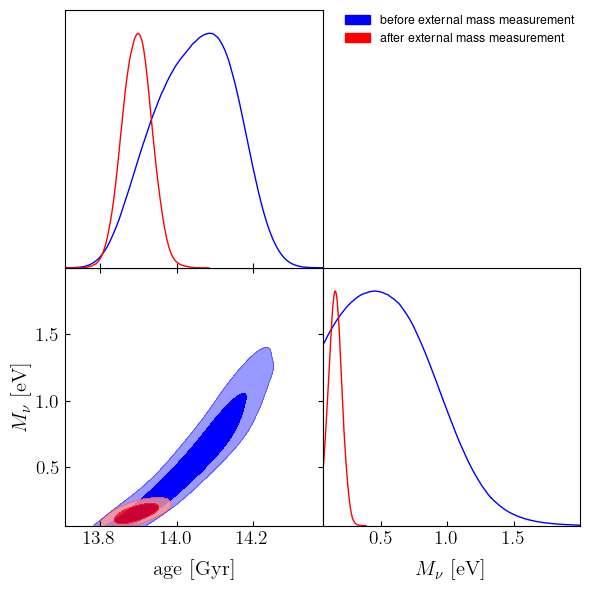

In [83]:
g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 6

g.settings.axes_fontsize = 15
g.settings.lab_fontsize =16

g.settings.legend_fontsize = 10
g.settings.alpha_filled_add=0.8
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False

g.settings.title_limit=0 #uncomment if you want to display marg stats.

sample_list = []
for s in range(len(all_samples)):

    sample_list.append(all_samples[s])
# g.add_x_bands(0.15, 0.05)
g.triangle_plot(sample_list,
    [
    # 'H0',
    'age',
    'm_ncdm',
    # 'yp2',
    ],

    filled=[True,True],
    legend_labels=[ 'before external mass measurement','after external mass measurement'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'1','color':'blue'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}]
                   )

plt.savefig('tri_actlite_TT_age_mnu_2d_1_2s_all.pdf')

### plot 2d

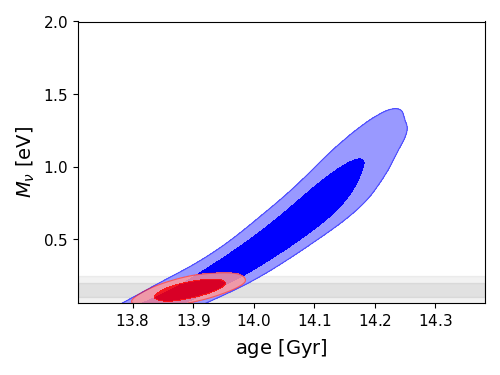

In [760]:
g = plots.get_single_plotter(width_inch=5)
g.add_y_bands(0.15, 0.05)
g.plot_2d([all_samples[0],
           all_samples[1]], 
          'age', 'm_ncdm', filled={True,True},colors=['blue','red']);

# g.export(path_to_chains_dir +'actlite_TT_age_mnu_mnu_prior_2d.pdf')
plt.savefig('actlite_TT_age_mnu_2d_1_2s_all.png',dpi=300)

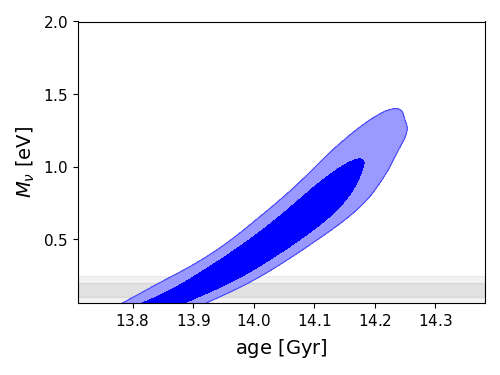

In [765]:
g = plots.get_single_plotter(width_inch=5)
g.add_y_bands(0.15, 0.05)
g.plot_2d([all_samples[0]],
           # all_samples[1]], 
          'age', 'm_ncdm', filled={True},colors=['blue']);

# g.export(path_to_chains_dir +'actlite_TT_age_mnu_mnu_prior_2d.pdf')
plt.savefig('actlite_TT_age_mnu_2d_1_2s_with_mnuprior.png',dpi=300)

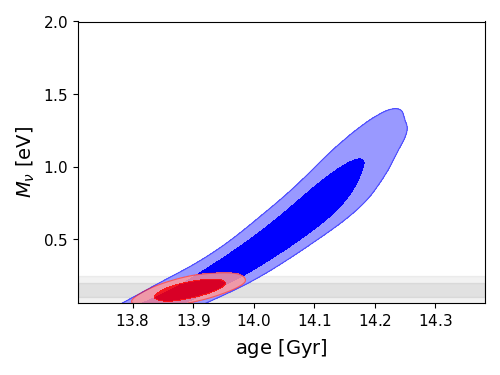

In [108]:
g = plots.get_single_plotter(width_inch=5)
g.add_y_bands(0.15, 0.05)
g.plot_2d([all_samples[0],
           all_samples[1]], 
          'age', 'm_ncdm', filled={True,True},colors=['blue','red']);

plt.savefig('actlite_TT_age_mnu_2d_1_2s.png',dpi=300)

### plot 1d both

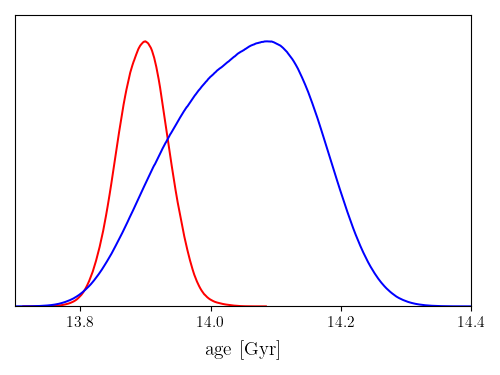

In [212]:
g = plots.get_single_plotter(width_inch=5)
g.settings.title_limit=0
g.plot_1d([all_samples[1],all_samples[0]], 'age', shaded=True,colors=['red','blue']);
ax = g.subplots[0,0]
# ax.axhline(1.03, color='gray', ls='--')
# mu = 14.005  # mean
# sigma = 0.005  # standard deviation
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)  # 100 points between (mean - 3*std) and (mean + 3*std)
# y = scipy.stats.norm.pdf(x, mu, sigma)  # Probability density function

# Plot the normal distribution
# ax.plot(x, y, label='Normal Distribution')
ax.set_xlim(13.7,14.4)
# ax.plot()
g.export(path_to_chains_dir +'actlite_TT_age_1d_mnu_prior.pdf')
plt.savefig(path_to_chains_dir +'actlite_TT_age_1d_mnu_prior.png',dpi=300)

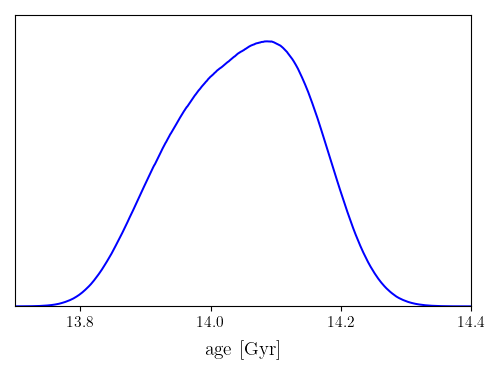

In [211]:
g = plots.get_single_plotter(width_inch=5)
g.settings.title_limit=0
g.plot_1d([all_samples[1],all_samples[0]], 'age', shaded=True,colors=['red','blue'],ls=['None','-']);
ax = g.subplots[0,0]
# ax.axhline(1.03, color='gray', ls='--')
# mu = 14.005  # mean
# sigma = 0.005  # standard deviation
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)  # 100 points between (mean - 3*std) and (mean + 3*std)
# y = scipy.stats.norm.pdf(x, mu, sigma)  # Probability density function

# Plot the normal distribution
# ax.plot(x, y, label='Normal Distribution')
ax.set_xlim(13.7,14.4)
# ax.plot()
g.export(path_to_chains_dir +'actlite_TT_age_1d_no_mnu_prior.pdf')
plt.savefig(path_to_chains_dir +'actlite_TT_age_1d_no_mnu_prior.png',dpi=300)

### plot 1d no neutrino mass measurement

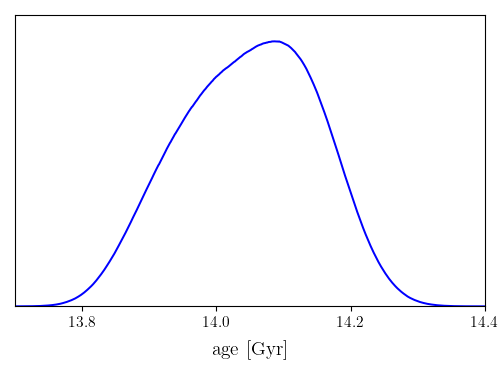

In [208]:
g = plots.get_single_plotter(width_inch=5)
g.settings.title_limit=0
g.plot_1d([all_samples[0]], 'age', shaded=True,colors=['blue']);
ax = g.subplots[0,0]
# ax.axhline(1.03, color='gray', ls='--')
# mu = 14.005  # mean
# sigma = 0.005  # standard deviation
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)  # 100 points between (mean - 3*std) and (mean + 3*std)
# y = scipy.stats.norm.pdf(x, mu, sigma)  # Probability density function

# Plot the normal distribution
# ax.plot(x, y, label='Normal Distribution')
ax.set_xlim(13.7,14.4)
# ax.plot()
g.export(path_to_chains_dir +'actlite_TT_age_1d_no_mnu_prior.pdf')
plt.savefig(path_to_chains_dir +'actlite_TT_age_1d_no_mnu_prior.png',dpi=300)

# Plot spectra

In [84]:
import pyactlike
# from getdist import loadMCSamples, MCSamples
# from getdist import plots
import os
import yaml
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [85]:
like = pyactlike.ACTPowerSpectrumData()

# Read an the spectrum from disk.
filename_wa = like.data_dir + "bf_ACTPol_lcdm.minimum.theory_cl"
tt_lmax = 5000

ell, dell_tt, dell_te, dell_ee = np.genfromtxt(
    filename_wa,
    delimiter=None,
    unpack=True,
    max_rows=tt_lmax - 1,
    usecols=(0, 1, 2, 3),
)

In [86]:
ell,ell.size

(array([2.000e+00, 3.000e+00, 4.000e+00, ..., 4.998e+03, 4.999e+03,
        5.000e+03]),
 4999)

In [87]:
%%time
like = pyactlike.ACTPowerSpectrumData(use_tt=True,use_te=False,use_ee=False)

chi2 = -2 * like.loglike(dell_tt, dell_te, dell_ee, 1.0)
print("ACT model chi2 = " + "{0:.2f}".format(chi2)+ " for 260 data points")

ACT model chi2 = 95.49 for 260 data points
CPU times: user 855 ms, sys: 1.94 s, total: 2.8 s
Wall time: 356 ms


In [88]:
like.nbintt,like.nbin
# np.zeros((1,1))
# np.linspace(

(40, 260)

## plotting the covmat

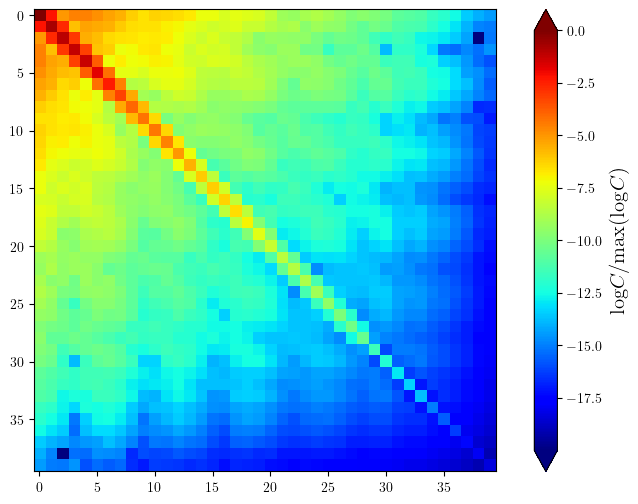

In [96]:
import matplotlib.cm as cm
fig = plt.figure(figsize=(10,6))
my_cov = like.cov_tt.copy()[:40,:40]
my_cov = np.abs(my_cov)/np.abs(my_cov).max()
# my_cov[np.abs(my_cov)<1e-4] = 1e-4
myim = plt.imshow(np.log(my_cov),cmap='jet')
cbar = plt.colorbar(myim,extend='both')
cbar.set_label(r"$\mathrm{log} C/\mathrm{max}(\mathrm{log} C)$",size=15)
plt.savefig('actlogabscov.pdf')

In [97]:
like.cov_tt.max()

9.593816168005338e-06

In [98]:
np.abs(like.cov_tt).min()

3.896010260235792e-15

(0.1, 6000)

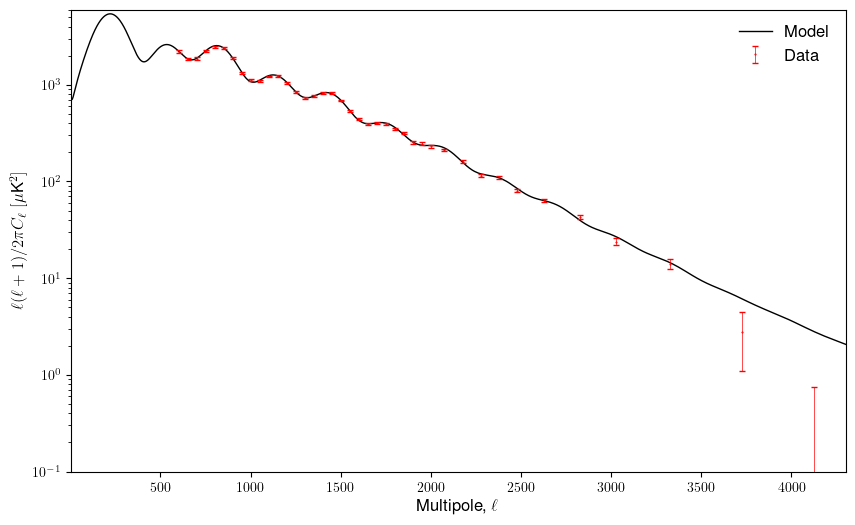

In [99]:


plt.figure(figsize=(10,6))

plt.plot(ell, dell_tt, "-", label="Model",lw=1.,c='k')

plt.errorbar(TT_bval,TT_dat,yerr = TT_err, marker='.',capsize=2,elinewidth=0.5,
             label="Data",markersize=1,ls='None',c='r')
plt.xlabel(r"Multipole, $\ell$",size=12)
plt.ylabel(r"$ \ell (\ell+1) / 2 \pi C_{\ell}$ $[\mu$K$^2]$",size=12)
plt.legend(fontsize=12,frameon=False)
plt.yscale('log')
# plt.xscale('log')

plt.xlim(2,4300)
plt.ylim(1e-1,6000)

### Data only

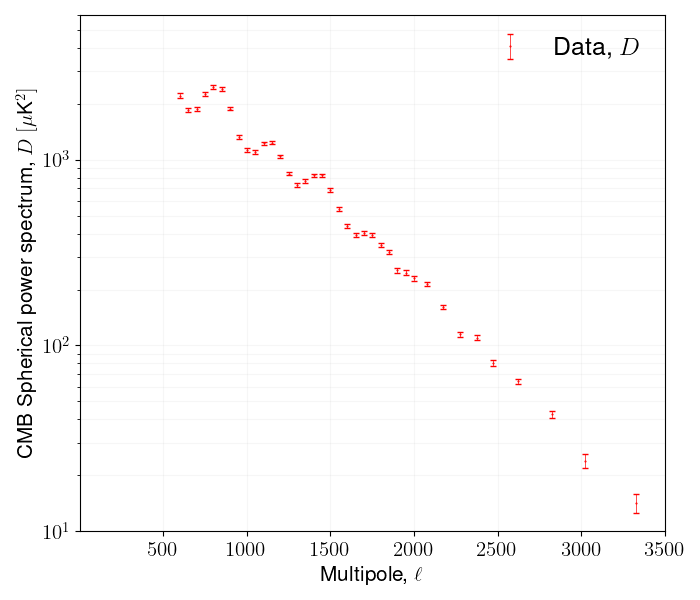

In [108]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,6))


# line, = plt.plot(ls,ls*(ls+1)/2./np.pi*compute_cls(age=13.8,m_nu=0.06)*(2.7255e6)**2,
#                  c='k',lw=0.8,label=r'Model, $D^\mathrm{th}=f(\mathrm{age},M_\nu)$')

plt.errorbar(TT_bval,TT_dat,yerr = TT_err, marker='.',capsize=2,elinewidth=0.5,
         label=r"Data, $D$",markersize=1,ls='None',c='r')

# plt.plot(ell, dell_tt, label="Best-Fit",lw=0.8,c='blue',ls='--')
plt.yscale('log')
plt.xlim(2,3500)
plt.ylim(1e1,6000)
# plt.title(r"Effect of $\Sigma m_\nu$ and age on $C_\ell$'s")
plt.xlabel(r"Multipole, $\ell$",size=15)
# plt.ylabel(r"$ \ell (\ell+1) / 2 \pi C_{\ell}$ $[\mu$K$^2]$",size=12)
plt.ylabel(r"CMB Spherical power spectrum, $ D$ $[\mu$K$^2]$",size=15)
plt.legend(frameon=False,fontsize = 18)
plt.grid(which='both',alpha=0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# interact(update, age = (13.,15,0.05), m_nu = (0.,2.,0.01));
fig.tight_layout()
plt.savefig("data_only.pdf")

ACT TT-wide diagonal chi2 = 39.28 for 40 data points


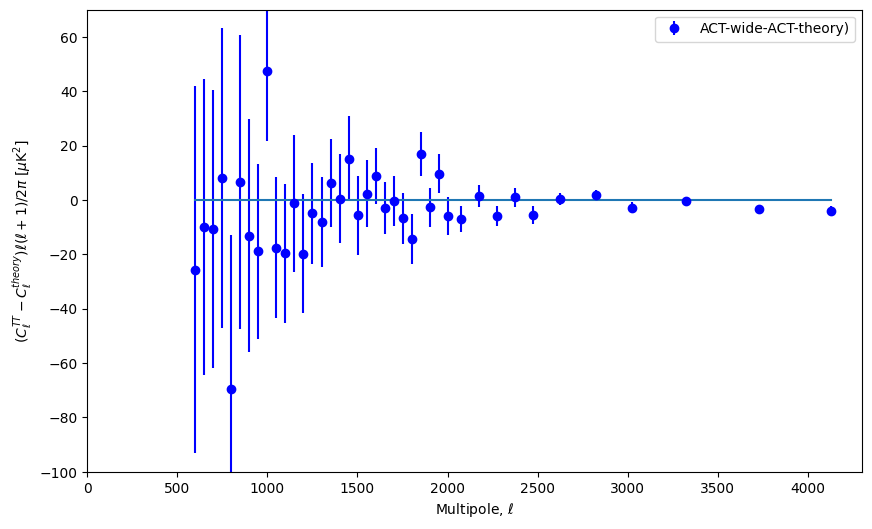

In [12]:
l_list = np.array(range(2, like.tt_lmax + 1))

#X_model[:nbintt] = cl_tt_d[b0 : b0 + nbintt]

#Bin TT
cltt = np.zeros(like.lmax_win)
#First turn theory Dell into Cell
cltt[1 : like.tt_lmax] = (dell_tt[: like.tt_lmax - 1] / l_list / (l_list + 1.0) * 2.0 * np.pi)
#now bin theory
bmax, lmax_win = like.bmax, like.lmax_win
cth_tt = like.win_func_w[2 * bmax : 3 * bmax, 1:lmax_win] @ cltt[1:lmax_win] 
#scale back to binned Dell by l(l+1)/2pi
dth_tt = cth_tt[like.b0:like.b0+like.nbintt]*like.bval[wmin:wmax]**2/(2.*np.pi) 

#Plot residuals
plt.figure(figsize=(10,6))
plt.errorbar(TT_bval,TT_dat-dth_tt,yerr = TT_err, fmt='bo',label="ACT-wide-ACT-theory)")
plt.plot(TT_bval, (TT_dat-dth_tt)*0.)
plt.xlabel(r"Multipole, $\ell$")
plt.ylabel(r"$(C_{\ell}^{TT}-C_{\ell}^{theory}) \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$")
plt.legend()
plt.xlim(0,4300)
plt.ylim(-100,70)


chi_act_TT = (TT_dat-dth_tt)**2/TT_err**2
print("ACT TT-wide diagonal chi2 = " + "{0:.2f}".format(np.sum(chi_act_TT))+ " for 40 data points")

In [13]:
like.fisher.shape

(80, 80)

In [14]:
len(TT_dat)

40

## Interactive plot

In [89]:
from classy_sz import Class

2023-11-22 03:13:30.087400: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-22 03:13:30.087418: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-22 03:13:30.087421: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-22 03:13:30.087752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-22 03:13:30.087894: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [90]:

def compute_cls(age=13.8, m_nu=0.06):


    cosmo = Class()
    
    new_cosmo_params = {
    'm_ncdm' : m_nu,
    'age' : age,
    }
    cosmo.set(new_cosmo_params)
    
    cosmo.set({
    'output' : 'tCl',
    'ln10^{10}A_s' : 3.0460125,
    'n_s': 1.0107972,
    'omega_b' : 0.021519356,
    'omega_cdm' : 0.11681165,
    'tau_reio' : 0.063418096,
    'skip_background_and_thermo' : 0,
    'skip_pkl' : 1, # for this run we dont need this
    'skip_pknl' : 1, # for this run we dont need this
    'skip_hubble' : 1, # for this run we dont need this
    'skip_sigma8_and_der' : 1, # for this run we dont need this
    'skip_sigma8_at_z' : 1, # for this run we dont need this
    'skip_chi' : 1, # for this run we dont need this
    # settings for 1 massive neutrino and 2 massless states
    'cosmo_model' : 1,
    'N_ncdm' : 1,
    'N_ur'  : 2.0308,
    })
    cosmo.compute_class_szfast()
    
    lensed_cls = cosmo.lensed_cl()
    l_fast = lensed_cls['ell']
    cl_tt_fast = lensed_cls['tt']



    return cl_tt_fast

In [91]:
ls = np.arange(0,20000)
ls

array([    0,     1,     2, ..., 19997, 19998, 19999])

In [92]:
%%time
cls = compute_cls()

CPU times: user 98.5 ms, sys: 25.3 ms, total: 124 ms
Wall time: 105 ms


In [93]:
cls.size

20000

In [101]:
wmin=130  #first element of TT for wide patch
wmax=130+40 #last element of TT for wide patch
                                                      
TT_bval=like.bval[wmin:wmax]
TT_dat=like.X_data[wmin:wmax]*like.bval[wmin:wmax]**2/(2.*np.pi)
TT_err=like.X_sig[wmin:wmax]*like.bval[wmin:wmax]**2/(2.*np.pi)

def plot_cls(lsp,clsp):
  plt.figure(figsize=(10,6))
  plt.plot(lsp,lsp*(lsp+1)/2./np.pi*clsp*(2.7255e6)**2,"-", label="Model",lw=1.,c='k')

  plt.errorbar(TT_bval,TT_dat,yerr = TT_err, marker='.',capsize=2,elinewidth=0.5,
             label="Data",markersize=1,ls='None',c='r')
    

  # plt.xscale('log')
  plt.yscale('log')
  plt.xlim(2,4300)
  # plt.ylim(1e-1,6000)
  plt.xlabel(r"Multipole, $\ell$",size=12)
  plt.ylabel(r"$ \ell (\ell+1) / 2 \pi C_{\ell}$ $[\mu$K$^2]$",size=12)
  plt.legend(frameon=False)
  plt.show()

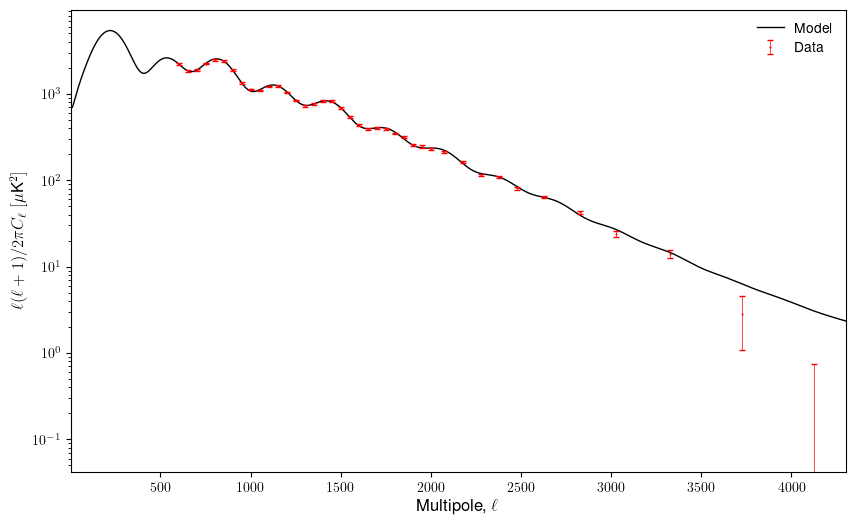

In [102]:
plot_cls(ls,cls)

interactive(children=(FloatSlider(value=14.8, description='age', max=15.0, min=13.0, step=0.05), FloatSlider(v…

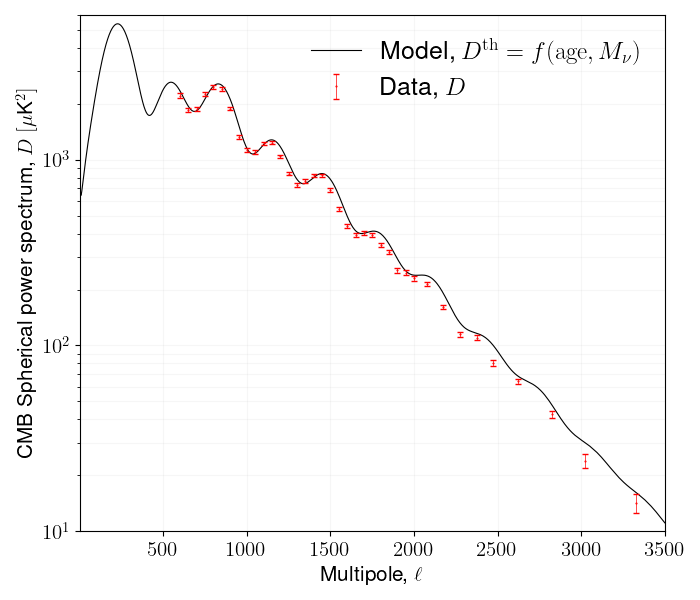

In [109]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,6))


line, = plt.plot(ls,ls*(ls+1)/2./np.pi*compute_cls(age=13.8,m_nu=0.06)*(2.7255e6)**2,
                 c='k',lw=0.8,label=r'Model, $D^\mathrm{th}=f(\mathrm{age},M_\nu)$')

plt.errorbar(TT_bval,TT_dat,yerr = TT_err, marker='.',capsize=2,elinewidth=0.5,
         label=r"Data, $D$",markersize=1,ls='None',c='r')

# plt.plot(ell, dell_tt, label="Best-Fit",lw=0.8,c='blue',ls='--')
plt.yscale('log')
plt.xlim(2,3500)
plt.ylim(1e1,6000)
# plt.title(r"Effect of $\Sigma m_\nu$ and age on $C_\ell$'s")
plt.xlabel(r"Multipole, $\ell$",size=15)
# plt.ylabel(r"$ \ell (\ell+1) / 2 \pi C_{\ell}$ $[\mu$K$^2]$",size=12)
plt.ylabel(r"CMB Spherical power spectrum, $ D$ $[\mu$K$^2]$",size=15)
plt.legend(frameon=False,fontsize = 18)
plt.grid(which='both',alpha=0.1)
def update(age = 14.8, m_nu = 0.86):

    line.set_ydata(ls*(ls+1)/2./np.pi*compute_cls(age,m_nu)*(2.7255e6)**2)
    fig.canvas.draw_idle()
    
interact(update, age = (13.,15,0.05), m_nu = (0.,2.,0.01));
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.tight_layout()
plt.savefig("interactiv_plot.pdf")

# Ploting the likelihood

In [119]:
len(dell_tt)

4999

In [126]:
ell

array([2.000e+00, 3.000e+00, 4.000e+00, ..., 4.998e+03, 4.999e+03,
       5.000e+03])

In [124]:
dell_tt

array([8.6091e+02, 8.1908e+02, 7.7773e+02, ..., 7.4355e-01, 7.4263e-01,
       7.4172e-01])

In [129]:
len(dell_tt_th)

4999

### likelihood of age

In [144]:
%%time


np_age = 100
age = np.linspace(13.6,14.1,np_age)
chi2s = []
for a in age:
    dell_tt_th = (ls*(ls+1)/2./np.pi*compute_cls(age=a,m_nu=0.06)*(2.7255e6)**2)[2:5001]

    like = pyactlike.ACTPowerSpectrumData(use_tt=True,use_te=False,use_ee=False)

    chi2s.append(-2 * like.loglike(dell_tt_th, dell_te, dell_ee, 1.0))
    # print("ACT model chi2 = " + "{0:.2f}".format(chi2)+ " for 260 data points")
chi2s = np.asarray(chi2s)

CPU times: user 1min 24s, sys: 3min 8s, total: 4min 32s
Wall time: 39.1 s


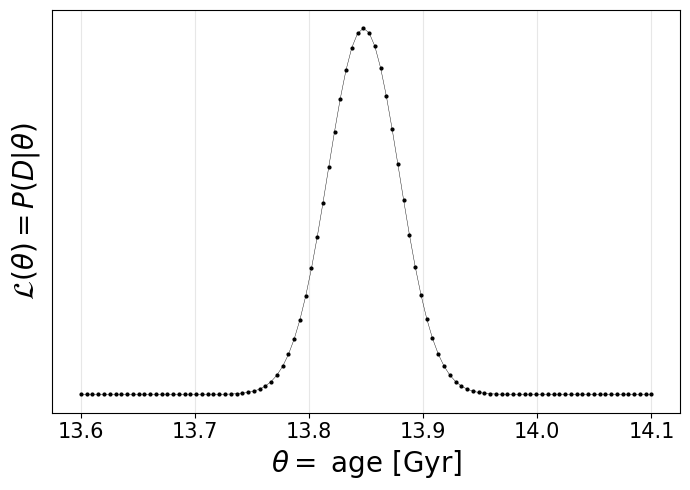

In [174]:
fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(age,np.exp(-1./2.*chi2s),marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = $ age [Gyr]',size=20)
plt.ylabel(r"$\mathcal{L}(\theta) = P(D|\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
fig.tight_layout()
plt.savefig("lkl_age.pdf")

### likelihood of Mnu

In [674]:
%%time


np_mnu = 100
mnu = np.linspace(0.,0.3,np_mnu)
chi2s_mnu = []
for a in mnu:
    dell_tt_th = (ls*(ls+1)/2./np.pi*compute_cls(age=13.8,m_nu=a)*(2.7255e6)**2)[2:5001]

    like = pyactlike.ACTPowerSpectrumData(use_tt=True,use_te=False,use_ee=False)

    chi2s_mnu.append(-2 * like.loglike(dell_tt_th, dell_te, dell_ee, 1.0))
    # print("ACT model chi2 = " + "{0:.2f}".format(chi2)+ " for 260 data points")
chi2s_mnu = np.asarray(chi2s_mnu)

CPU times: user 1min 17s, sys: 3min 11s, total: 4min 29s
Wall time: 37 s


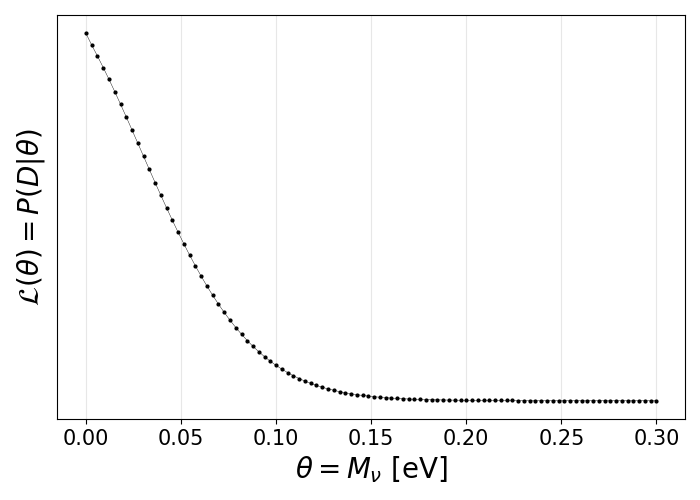

In [675]:
fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(mnu,np.exp(-1./2.*chi2s_mnu),marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta =  M_\nu$ [eV]',size=20)
plt.ylabel(r"$\mathcal{L}(\theta) = P(D|\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
fig.tight_layout()
plt.savefig("lkl_mnu.pdf")

### A gaussian prior on Mnu

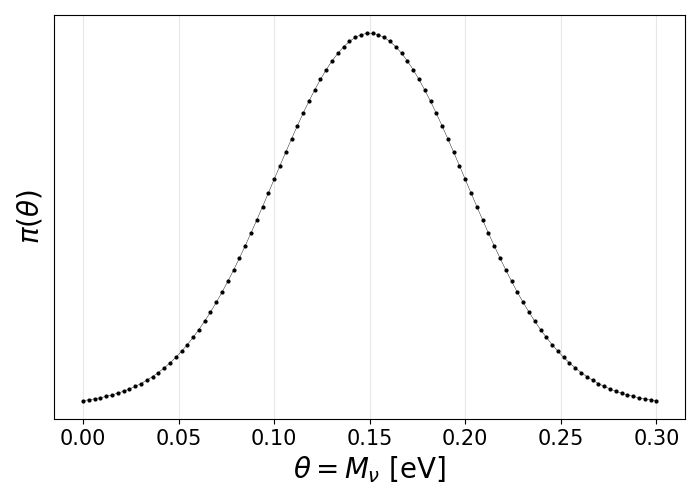

In [676]:
from scipy.stats import norm
fig, ax  = plt.subplots(figsize=(7,5))
mu = 0.15
sigma = 0.05

x = mnu
y = norm.pdf(x, mu, sigma)  
plt.plot(x,y,marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta =  M_\nu$ [eV]',size=20)
plt.ylabel(r"$\pi(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
fig.tight_layout()
plt.savefig("prior_mnu.pdf")

### posterior on Mnu with gaussian prior

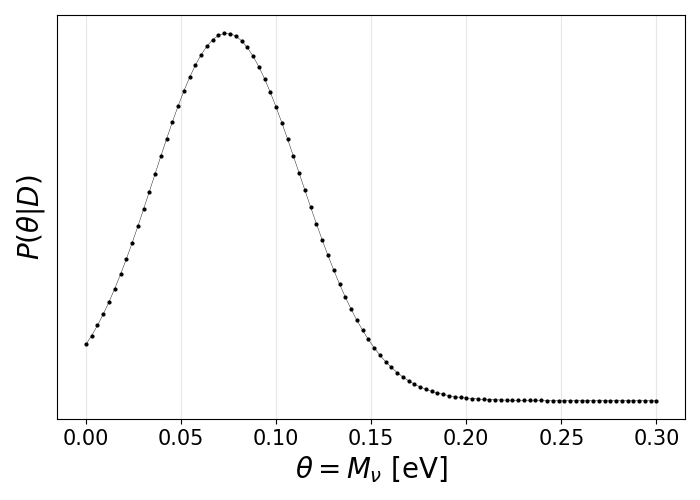

In [677]:
from scipy.stats import norm
fig, ax  = plt.subplots(figsize=(7,5))
mu = 0.15
sigma = 0.05

x = mnu
y = norm.pdf(x, mu, sigma)  
plt.plot(x,y*np.exp(-1./2.*chi2s_mnu),marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta =  M_\nu$ [eV]',size=20)
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
fig.tight_layout()
plt.savefig("posterior_mnu.pdf")

### uniform prior on mnu

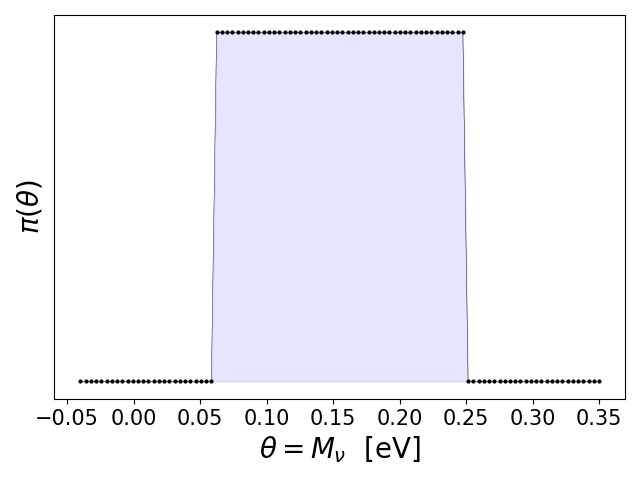

In [679]:
a = 0.06
b = 0.25
u_mnu_x = np.linspace(a - 0.1, b + 0.1, 100)
u_mnu_pdf = scipy.stats.uniform.pdf(u_mnu_x, loc=a, scale=b-a)
fig,ax = plt.subplots()
plt.plot(u_mnu_x, u_mnu_pdf, marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = M_\nu$  [eV]',size=20)
plt.ylabel(r"$\pi(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
plt.fill_between(u_mnu_x,u_mnu_pdf,color='blue',alpha=0.1)
# plt.xlim(13.6,14.1)
fig.tight_layout()
plt.show()
plt.savefig('mnu_prior_uniform.pdf')

### posterior on mnu with uniform prior

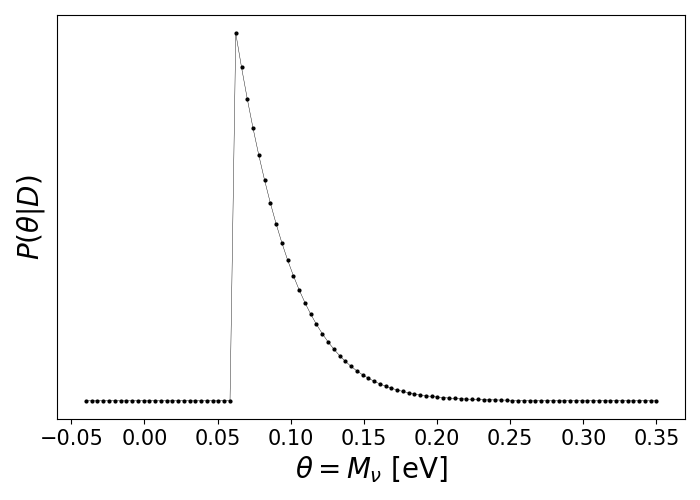

In [680]:
from scipy.stats import norm
fig, ax  = plt.subplots(figsize=(7,5))
 
plt.plot(u_mnu_x,u_mnu_pdf*np.exp(-1./2.*chi2s_mnu),marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta =  M_\nu$ [eV]',size=20)
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
fig.tight_layout()
plt.savefig("posterior_mnu_uniform.pdf")

### log-uniform prior on mnu

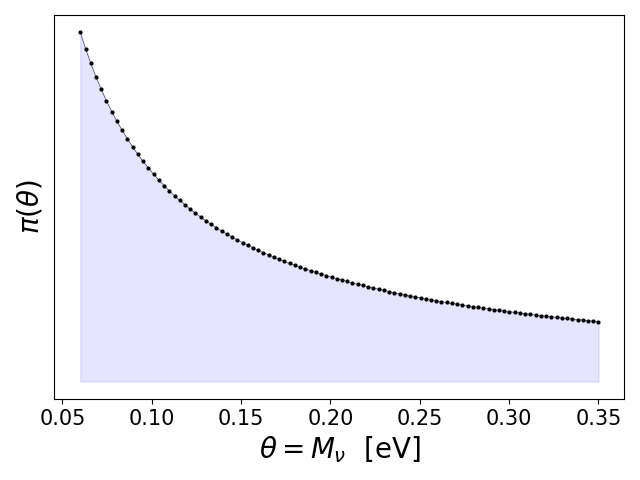

In [686]:
a = 0.06
b = 0.25
u_lnmnu_x = np.linspace(a, b + 0.1, 100)
u_lnmnu_pdf = 1./u_lnmnu_x/np.log(b/a)
fig,ax = plt.subplots()
plt.plot(u_lnmnu_x, u_lnmnu_pdf, marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = M_\nu$  [eV]',size=20)
plt.ylabel(r"$\pi(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
plt.fill_between(u_lnmnu_x,u_lnmnu_pdf,color='blue',alpha=0.1)
# plt.xlim(13.6,14.1)
fig.tight_layout()
plt.show()
plt.savefig('mnu_prior_uniform.pdf')

### posterior on mnu with uniform prior

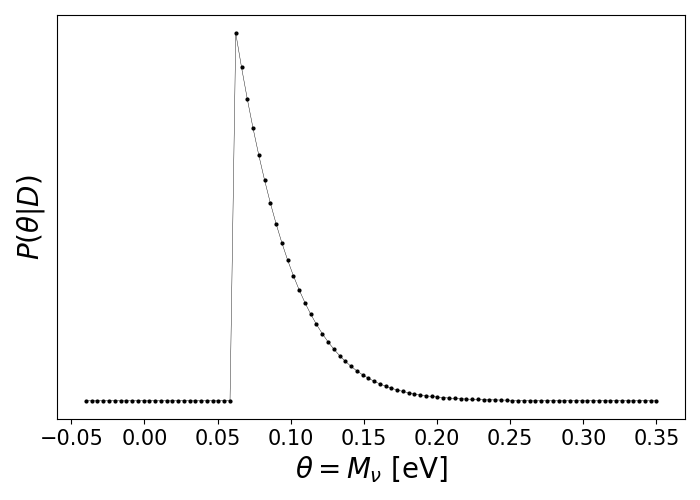

In [687]:
from scipy.stats import norm
fig, ax  = plt.subplots(figsize=(7,5))
 
plt.plot(u_mnu_x,u_mnu_pdf*np.exp(-1./2.*chi2s_mnu),marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta =  M_\nu$ [eV]',size=20)
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
fig.tight_layout()
plt.savefig("posterior_mnu_uniform.pdf")

### posterior on mnu with log-uniform prior

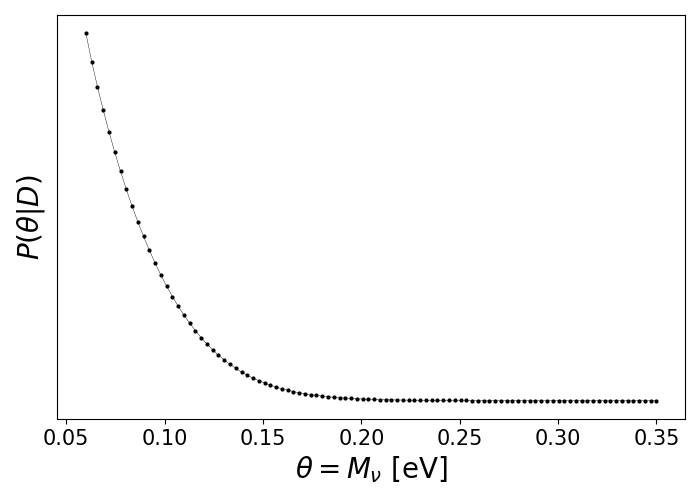

In [691]:
from scipy.stats import norm
fig, ax  = plt.subplots(figsize=(7,5))
 
plt.plot(u_lnmnu_x,u_lnmnu_pdf*np.exp(-1./2.*chi2s_mnu),marker='o',c='k',ls='-',lw=0.3,markersize= 2,label='From log-uniform prior')
plt.xlabel(r'$\theta =  M_\nu$ [eV]',size=20)
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
fig.tight_layout()
plt.savefig("posterior_mnu_loguniform.pdf")

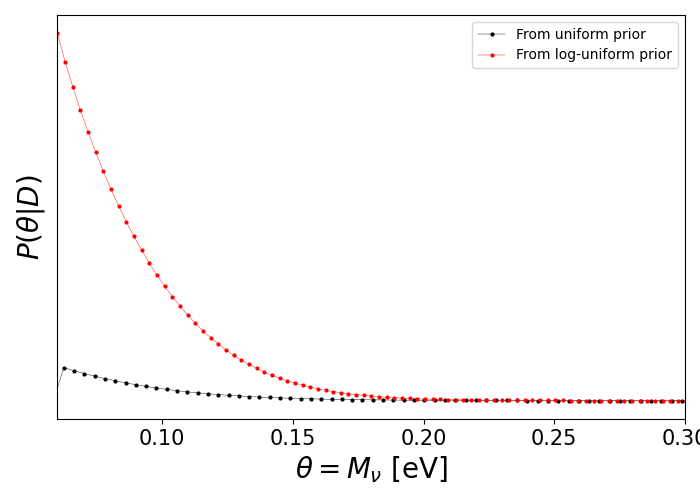

In [710]:
from scipy.stats import norm
fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(u_mnu_x,u_mnu_pdf*np.exp(-1./2.*chi2s_mnu),marker='o',c='k',ls='-',lw=0.3,markersize= 2,label='From uniform prior')
plt.plot(u_lnmnu_x,u_lnmnu_pdf*np.exp(-1./2.*chi2s_mnu),marker='o',c='r',ls='-',lw=0.3,markersize= 2,label='From log-uniform prior')
plt.xlabel(r'$\theta =  M_\nu$ [eV]',size=20)
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
fig.tight_layout()
plt.legend()
plt.xlim(0.06,0.3)
plt.savefig("posterior_mnu_loguniform_vs_uniform.pdf")

# 2D likelihood

In [715]:
%%time


np_age = 10
age = np.linspace(13.7,14.4,np_age)
np_mnu = 10
mnu = np.linspace(0.,2.,np_mnu)

lkl_age_mnu = np.zeros((len(mnu),len(age)))


for a in age:
    for b in mnu:
        i = np.where(age == a)
        j = np.where(mnu == b)
        dell_tt_th = (ls*(ls+1)/2./np.pi*compute_cls(age=a,m_nu=b)*(2.7255e6)**2)[2:5001]

        like = pyactlike.ACTPowerSpectrumData(use_tt=True,use_te=False,use_ee=False)

        lkl_age_mnu[j,i] = np.exp(like.loglike(dell_tt_th, dell_te, dell_ee, 1.0))



CPU times: user 1min 17s, sys: 3min 17s, total: 4min 35s
Wall time: 36.7 s


In [716]:
np.save('lkl_age_mnu.npy',lkl_age_mnu)

In [5]:
lkl_age_mnu = np.load('lkl_age_mnu_100_100.npy')

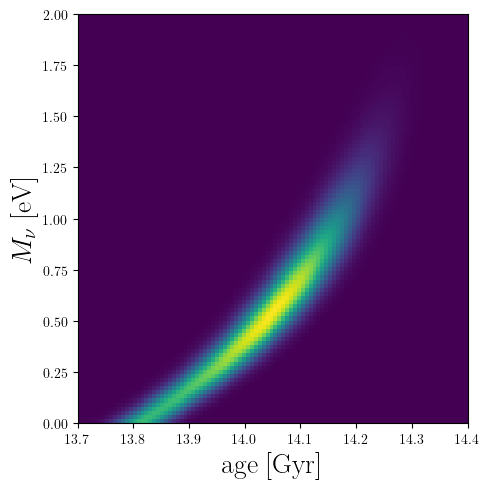

In [72]:
fig,ax = plt.subplots(figsize=(5,5))
np_age = 100
age = np.linspace(13.7,14.4,np_age)
np_mnu = 100
mnu = np.linspace(0.,2.,np_mnu)
plt.imshow(lkl_age_mnu,origin='lower',
           extent=[min(age), max(age), min(mnu), max(mnu)])
ax.set_aspect("auto")
plt.xlabel(r'$\mathrm{age}$  $\mathrm{[Gyr]}$',size=20)
plt.ylabel(r'$M_\nu$  $\mathrm{[eV]}$',size=20)
# plt.show()
fig.tight_layout()
plt.savefig('lkl_2d_flat.pdf')

/var/folders/h0/4_tf3pcn1h32ks9grh325v400000gn/T/ipykernel_99688/4159817894.py:44: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.line.set_lw(0.)


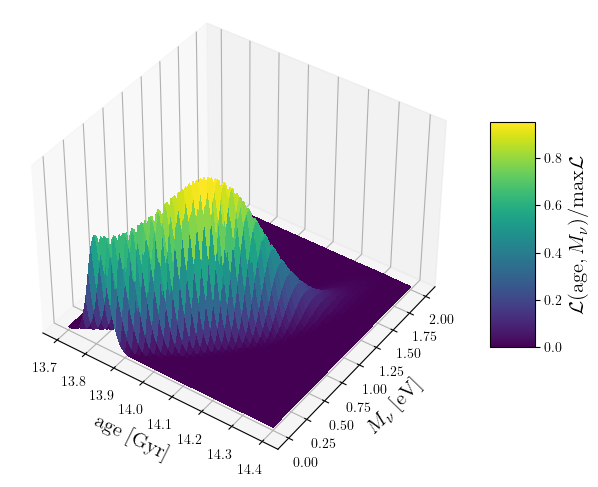

In [59]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
font = {'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

np_age = 100
age = np.linspace(13.7,14.4,np_age)
np_mnu = 100
mnu = np.linspace(0.,2.,np_mnu)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = age
Y = mnu
X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
Z = lkl_age_mnu/lkl_age_mnu.max()

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter(r'${x:.01f}$')
ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])
ax.set_xlabel(r'$\mathrm{age}$ $[\mathrm{Gyr}]$', fontsize=15, rotation=60)
ax.set_ylabel(r'$M_\nu$ $\mathrm{[eV]}$', fontsize=15, rotation=60)
# ax.set_zlabel('$g_4$', fontsize=15, rotation=60)
# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)

cbar.set_label(r"$\mathcal{L}(\mathrm{age},M_\nu)/\mathrm{max}\mathcal{L}$",size=15)

ax.view_init(elev=40, azim=-55)
fig.tight_layout()
# plt.show()
plt.savefig('lkl_2d.pdf')

# 1 D posterior on age -- 2 cases

#### Prior on age uniform 1

In [195]:
u_age_x

array([13.6       , 13.60505051, 13.61010101, 13.61515152, 13.62020202,
       13.62525253, 13.63030303, 13.63535354, 13.64040404, 13.64545455,
       13.65050505, 13.65555556, 13.66060606, 13.66565657, 13.67070707,
       13.67575758, 13.68080808, 13.68585859, 13.69090909, 13.6959596 ,
       13.7010101 , 13.70606061, 13.71111111, 13.71616162, 13.72121212,
       13.72626263, 13.73131313, 13.73636364, 13.74141414, 13.74646465,
       13.75151515, 13.75656566, 13.76161616, 13.76666667, 13.77171717,
       13.77676768, 13.78181818, 13.78686869, 13.79191919, 13.7969697 ,
       13.8020202 , 13.80707071, 13.81212121, 13.81717172, 13.82222222,
       13.82727273, 13.83232323, 13.83737374, 13.84242424, 13.84747475,
       13.85252525, 13.85757576, 13.86262626, 13.86767677, 13.87272727,
       13.87777778, 13.88282828, 13.88787879, 13.89292929, 13.8979798 ,
       13.9030303 , 13.90808081, 13.91313131, 13.91818182, 13.92323232,
       13.92828283, 13.93333333, 13.93838384, 13.94343434, 13.94

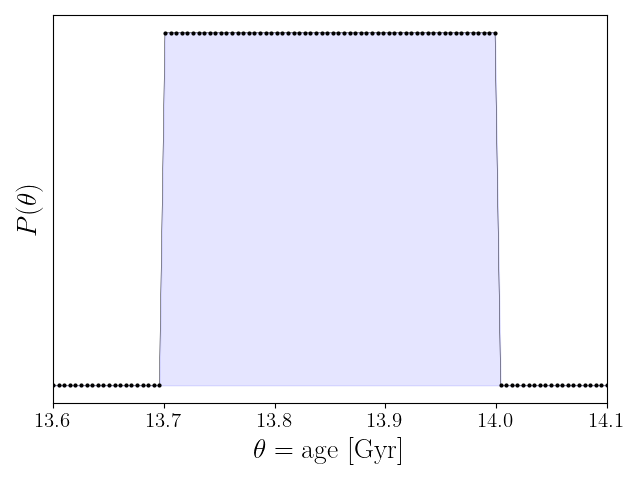

In [118]:
a = 13.7
b = 14.
u_age_x = np.linspace(a - 0.1, b + 0.1, 100)
u_age_pdf = scipy.stats.uniform.pdf(u_age_x, loc=a, scale=b-a)
fig,ax = plt.subplots()
plt.plot(u_age_x, u_age_pdf, marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
plt.ylabel(r"$P(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
plt.fill_between(u_age_x,u_age_pdf,color='blue',alpha=0.1)
plt.xlim(13.6,14.1)
fig.tight_layout()
plt.show()
plt.savefig('age_prior_uniform.pdf')
plt.savefig('age_prior_uniform.png',dpi=300)

#### lkl on age uniform 1

In [119]:
%%time
age = u_age_x
lkl_age = []
for a in age:
    dell_tt_th = (ls*(ls+1)/2./np.pi*compute_cls(age=a,m_nu=0.06)*(2.7255e6)**2)[2:5001]

    like = pyactlike.ACTPowerSpectrumData(use_tt=True,use_te=False,use_ee=False)

    lkl_age.append(np.exp(like.loglike(dell_tt_th, dell_te, dell_ee, 1.0)))
    # print("ACT model chi2 = " + "{0:.2f}".format(chi2)+ " for 260 data points")
lkl_age = np.asarray(lkl_age)

CPU times: user 1min 19s, sys: 3min 10s, total: 4min 29s
Wall time: 37.8 s


In [122]:
np.save('lkl_age.npy',lkl_age)

In [123]:
lkl_age = np.load('lkl_age.npy')

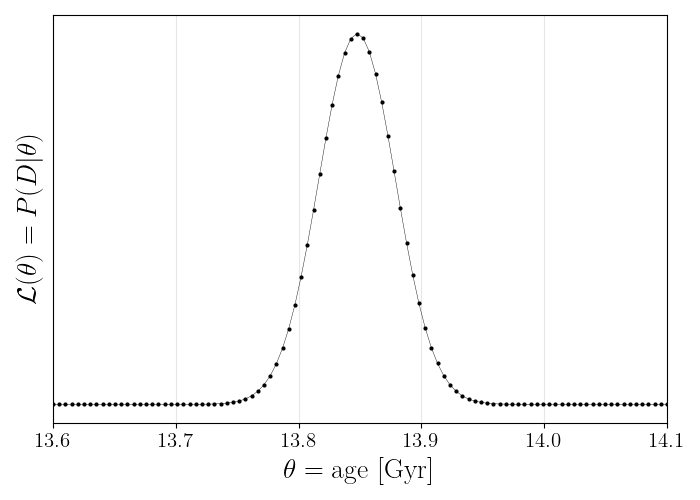

In [125]:
fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(age,lkl_age,marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
plt.ylabel(r"$\mathcal{L}(\theta) = P(D|\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
plt.xlim(13.6,14.1)
fig.tight_layout()
plt.savefig("lkl_age_u.pdf")
plt.savefig("lkl_age_u.png",dpi=300)

#### posterior on age uniform 1

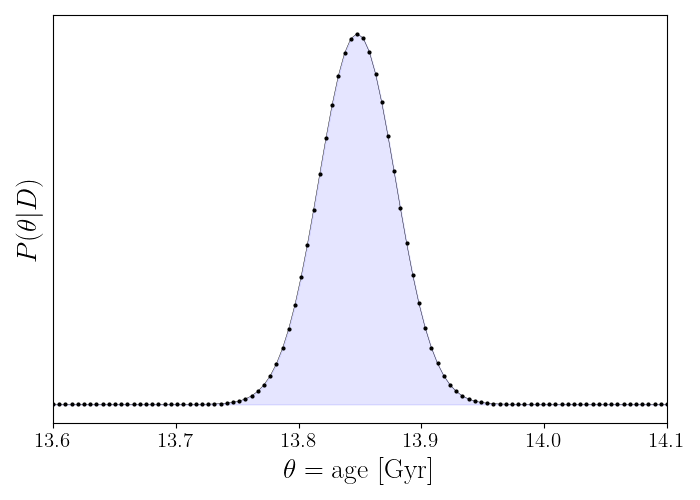

In [126]:
from scipy.stats import norm
fig, ax  = plt.subplots(figsize=(7,5))


plt.plot(age,u_age_pdf*lkl_age,marker='o',c='k',ls='-',lw=0.3,markersize= 2)

plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)

plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
plt.fill_between(u_age_x,u_age_pdf*lkl_age,color='blue',alpha=0.1)
plt.xlim(13.6,14.1)
fig.tight_layout()

plt.savefig("posterior_age_u1.pdf")
plt.savefig("posterior_age_u1.png",dpi=300)

#### Prior on age wide gaussian unzoomed

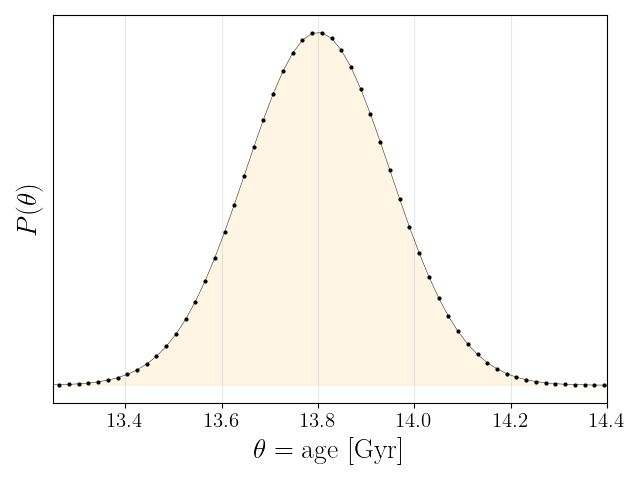

In [127]:
import scipy
wide_scale = 0.15
u_age_x_wide_unzoomed = np.linspace(13,15,100)
u_age_pdf_wide_unzoomed = scipy.stats.norm.pdf(u_age_x_wide_unzoomed, loc=13.8, scale=wide_scale)
fig,ax = plt.subplots()
plt.plot(u_age_x_wide_unzoomed, u_age_pdf_wide_unzoomed, marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
plt.ylabel(r"$P(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
plt.fill_between(u_age_x_wide_unzoomed,u_age_pdf_wide_unzoomed,color='orange',alpha=0.1)
plt.xlim(13.25,14.4)
fig.tight_layout()

plt.show()
plt.savefig("posterior_age_u2_gaussian.pdf")
plt.savefig("posterior_age_u2_gaussian.png",dpi=300)

#### Prior on age wide gaussian unzoomed compare with uniform

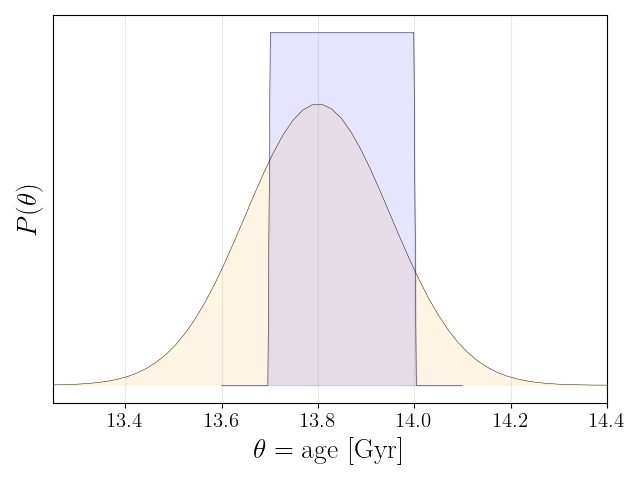

In [197]:
import scipy
wide_scale = 0.15
u_age_x_wide_unzoomed = np.linspace(13,15,100)
u_age_pdf_wide_unzoomed = scipy.stats.norm.pdf(u_age_x_wide_unzoomed, loc=13.8, scale=wide_scale)
fig,ax = plt.subplots()
plt.plot(u_age_x_wide_unzoomed, u_age_pdf_wide_unzoomed, marker='o',c='k',ls='-',lw=0.3,markersize= 0)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
plt.ylabel(r"$P(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
plt.fill_between(u_age_x_wide_unzoomed,u_age_pdf_wide_unzoomed,color='orange',alpha=0.1)


a = 13.7
b = 14.
u_age_x = np.linspace(a - 0.1, b + 0.1, 100)
u_age_pdf = scipy.stats.uniform.pdf(u_age_x, loc=a, scale=b-a)
plt.plot(u_age_x, u_age_pdf, marker='o',c='k',ls='-',lw=0.3,markersize= 0) 
# plt.grid(which='both',alpha=0.3)
plt.fill_between(u_age_x,u_age_pdf,color='blue',alpha=0.1)


plt.xlim(13.25,14.4)
fig.tight_layout()

plt.show()
plt.savefig("posterior_age_u2_gaussian_vs_uni.pdf")
plt.savefig("posterior_age_u2_gaussian_vs_uni.png",dpi=300)

#### Prior on age wide gaussian zoom

0.15


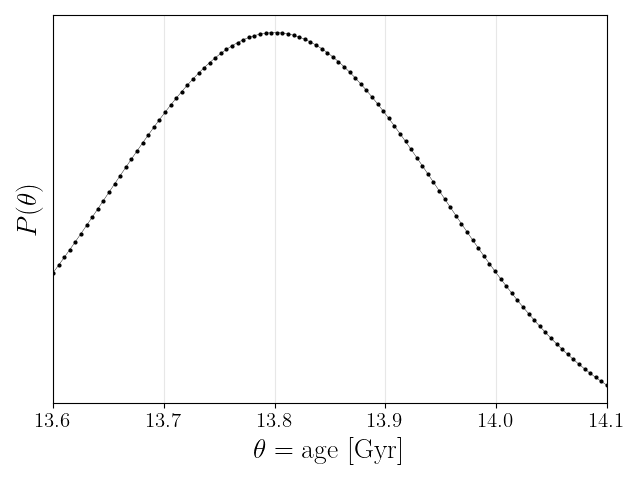

In [129]:
u_age_pdf_wide = scipy.stats.norm.pdf(u_age_x, loc=13.8, scale=wide_scale)
print(wide_scale)
fig,ax = plt.subplots()

plt.plot(u_age_x, u_age_pdf_wide, marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
plt.ylabel(r"$P(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
plt.xlim(13.6,14.1)
fig.tight_layout()

plt.show()


#### posterior on age wide gaussian

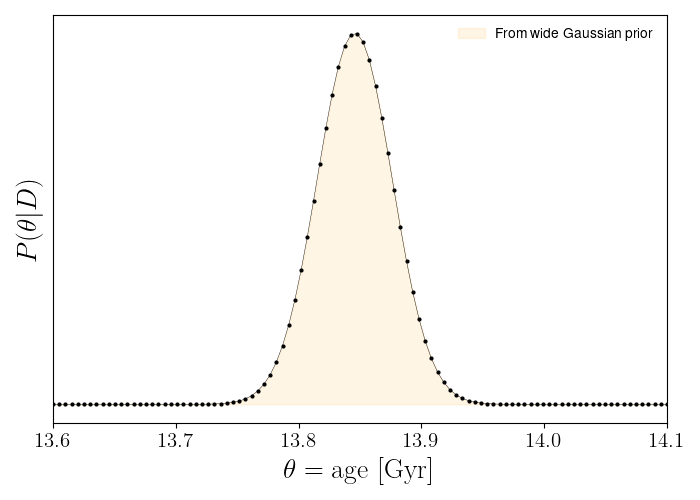

In [130]:
from scipy.stats import norm
fig, ax  = plt.subplots(figsize=(7,5))


plt.plot(u_age_x,u_age_pdf_wide*lkl_age,marker='o',c='k',ls='-',lw=0.3,markersize= 2)

plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)

plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
plt.xlim(13.6,14.1)
plt.fill_between(u_age_x,u_age_pdf_wide*lkl_age,color='orange',alpha=0.1,label='From wide Gaussian prior')
plt.legend(frameon=False)
fig.tight_layout()

plt.savefig("posterior_age_wg.pdf")
plt.savefig("posterior_age_wg.png",dpi=300)

### approximate comparison of both posteriors

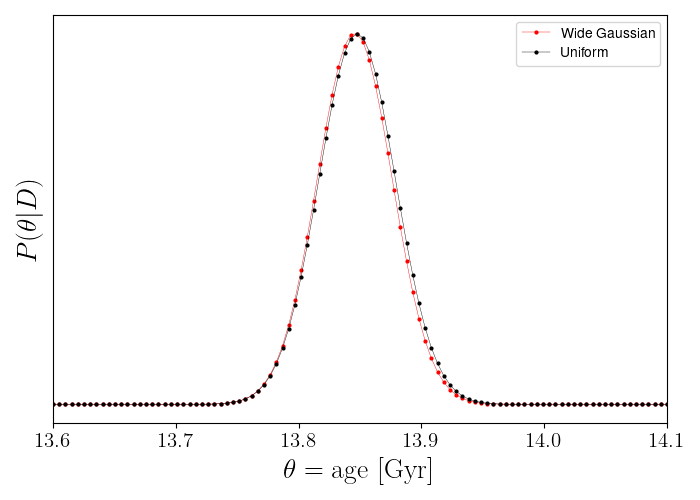

In [131]:
from scipy.stats import norm
fig, ax  = plt.subplots(figsize=(7,5))


plt.plot(u_age_x,u_age_pdf_wide*lkl_age/np.max(u_age_pdf_wide*lkl_age),marker='o',c='r',ls='-',lw=0.3,markersize= 2,label='Wide Gaussian')
plt.plot(u_age_x,u_age_pdf*lkl_age/np.max(u_age_pdf*lkl_age),marker='o',c='k',ls='-',lw=0.3,markersize= 2,label='Uniform')

plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)

plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
plt.xlim(13.6,14.1)
plt.legend()
fig.tight_layout()

plt.savefig("posterior_age_wg_vs_u.pdf")
plt.savefig("posterior_age_wg_vs_u.png",dpi=300)

### Simple KDE to find the credible intervals

##### Uniform prior

In [159]:
from scipy.optimize import curve_fit
# Define the Gaussian (normal) distribution function
def gaussian(x,  amplitude, mean, stddev):
    return amplitude/(np.sqrt(2.*np.pi*stddev**2)) * np.exp(-((x - mean) / stddev) ** 2 / 2)

fit_params, covariance = curve_fit(gaussian, u_age_x, u_age_pdf*lkl_age, p0=[1e-23, 15.,2.])



In [160]:
fit_params

array([1.13847510e-22, 1.38476430e+01, 3.12302211e-02])

In [161]:
y_fit = gaussian(u_age_x, *fit_params)

In [162]:
# y_fit

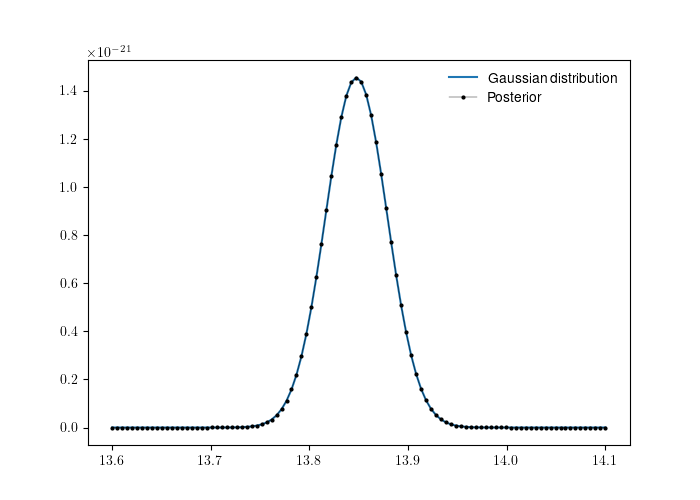

In [163]:
fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(u_age_x,y_fit,label='Gaussian distribution')
plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='-',lw=0.3,markersize= 2.,label='Posterior')
plt.legend(frameon=False)
plt.show()

In [164]:
gaussian_pdf = norm.pdf(u_age_x, loc=fit_params[1], scale=np.abs(fit_params[2]))

In [165]:
sigma_1_interval = fit_params[1] + np.array([-1, 1]) * np.abs(fit_params[2])
sigma_1_interval

array([13.81641274, 13.87887319])

In [166]:
sigma_2_interval = fit_params[1] + np.array([-2, 2]) * np.abs(fit_params[2])
sigma_2_interval

array([13.78518252, 13.91010341])

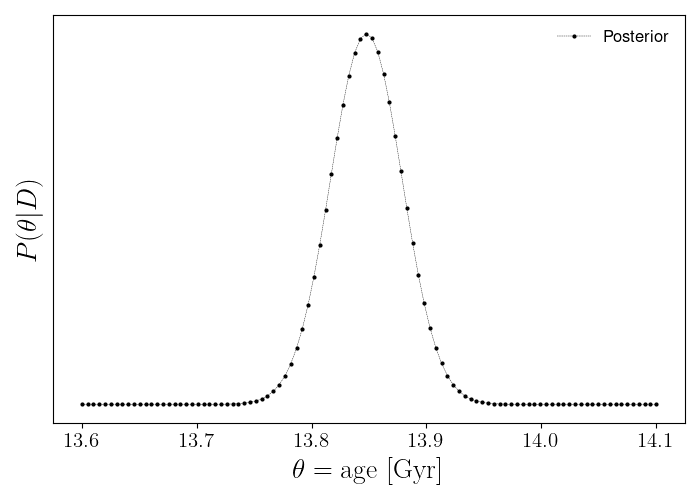

In [167]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='--',lw=0.3,markersize= 2.,label='Posterior')

# plt.plot(u_age_x,y_fit,label=r'$\mathcal{N}(\mu,\sigma)$',c='b',lw=0.6)


# plt.plot(u_age_x,gaussian_pdf*fit_params[0])
# # Plot confidence intervals


# plt.axvline(sigma_1_interval[0],ymin = 0,ymax = 1, color='green',  linestyle='--',lw=0.4, label='68% CL')
# plt.axvline(sigma_1_interval[1],ymin = 0,ymax = 1, color='green', linestyle='--',lw=0.4)

# plt.axvline(sigma_2_interval[0], ymax = 1., color='orange',lw=0.4, linestyle='--', label='95% CL')
# plt.axvline(sigma_2_interval[1], ymax = 1., color='orange',lw=0.4, linestyle='--')

# plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],
#                  fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],color='green',alpha=0.1)

# plt.fill_between(u_age_x[(u_age_x<sigma_1_interval[0]) & (u_age_x>sigma_2_interval[0])],
#                  fit_params[0]*gaussian_pdf[(u_age_x<sigma_1_interval[0]) & (u_age_x>sigma_2_interval[0])],color='orange',alpha=0.1)

# plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[1]) & (u_age_x<sigma_2_interval[1])],
#                  fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[1]) & (u_age_x<sigma_2_interval[1])],color='orange',alpha=0.1)
# plt.title('Normal Distribution with Confidence Intervals')
# plt.xlabel('Value')
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)

# plt.ylabel('Probability Density')
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()
plt.show()
plt.savefig('posterior_only_age.png',dpi=300)
plt.savefig('posterior_only_age.pdf')


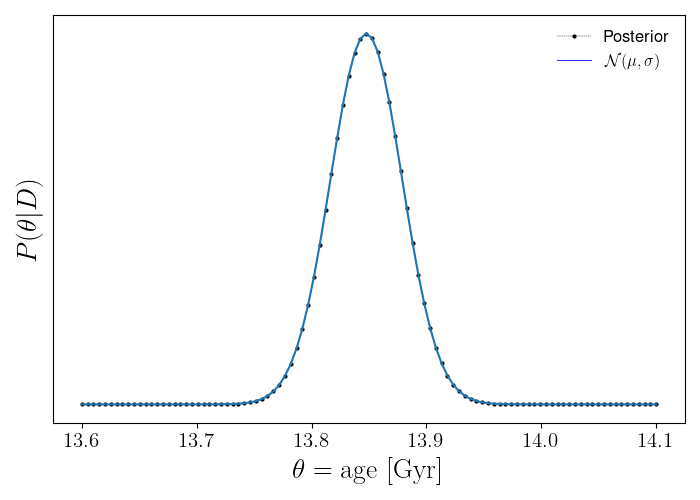

In [168]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='--',lw=0.3,markersize= 2.,label='Posterior')
plt.plot(u_age_x,y_fit,label=r'$\mathcal{N}(\mu,\sigma)$',c='b',lw=0.6)


plt.plot(u_age_x,gaussian_pdf*fit_params[0])
# Plot confidence intervals


# plt.axvline(sigma_1_interval[0],ymin = 0,ymax = 1, color='green',  linestyle='--',lw=0.4, label='68% CL')
# plt.axvline(sigma_1_interval[1],ymin = 0,ymax = 1, color='green', linestyle='--',lw=0.4)

# plt.axvline(sigma_2_interval[0], ymax = 1., color='orange',lw=0.4, linestyle='--', label='95% CL')
# plt.axvline(sigma_2_interval[1], ymax = 1., color='orange',lw=0.4, linestyle='--')

# plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],
#                  fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],color='green',alpha=0.1)

# plt.fill_between(u_age_x[(u_age_x<sigma_1_interval[0]) & (u_age_x>sigma_2_interval[0])],
#                  fit_params[0]*gaussian_pdf[(u_age_x<sigma_1_interval[0]) & (u_age_x>sigma_2_interval[0])],color='orange',alpha=0.1)

# plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[1]) & (u_age_x<sigma_2_interval[1])],
#                  fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[1]) & (u_age_x<sigma_2_interval[1])],color='orange',alpha=0.1)
# plt.title('Normal Distribution with Confidence Intervals')
# plt.xlabel('Value')
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)

# plt.ylabel('Probability Density')
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()

plt.savefig('posterior_only_age_plus_gauss.png',dpi=300)
plt.savefig('posterior_only_age_plus_gauss.pdf')


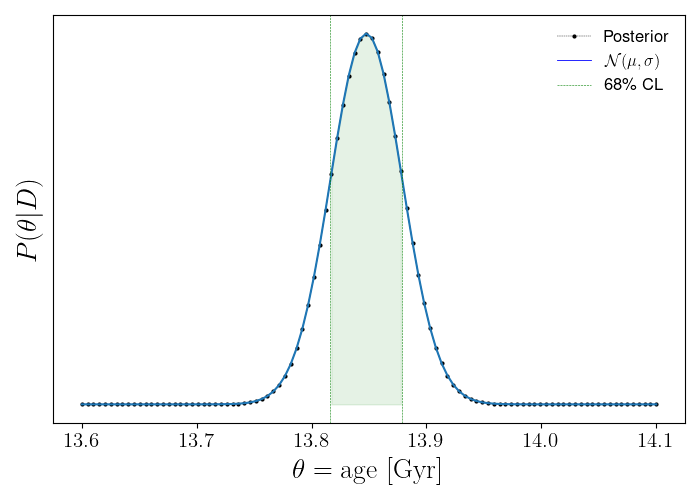

In [171]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='--',lw=0.3,markersize= 2.,label='Posterior')
plt.plot(u_age_x,y_fit,label=r'$\mathcal{N}(\mu,\sigma)$',c='b',lw=0.6)


plt.plot(u_age_x,gaussian_pdf*fit_params[0])
# Plot confidence intervals


plt.axvline(sigma_1_interval[0],ymin = 0,ymax = 1, color='green',  linestyle='--',lw=0.4, label='68\% CL')
plt.axvline(sigma_1_interval[1],ymin = 0,ymax = 1, color='green', linestyle='--',lw=0.4)

# plt.axvline(sigma_2_interval[0], ymax = 1., color='orange',lw=0.4, linestyle='--', label='95% CL')
# plt.axvline(sigma_2_interval[1], ymax = 1., color='orange',lw=0.4, linestyle='--')

plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],
                 fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],color='green',alpha=0.1)

# plt.fill_between(u_age_x[(u_age_x<sigma_1_interval[0]) & (u_age_x>sigma_2_interval[0])],
#                  fit_params[0]*gaussian_pdf[(u_age_x<sigma_1_interval[0]) & (u_age_x>sigma_2_interval[0])],color='orange',alpha=0.1)

# plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[1]) & (u_age_x<sigma_2_interval[1])],
#                  fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[1]) & (u_age_x<sigma_2_interval[1])],color='orange',alpha=0.1)
# plt.title('Normal Distribution with Confidence Intervals')
# plt.xlabel('Value')
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)

# plt.ylabel('Probability Density')
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()

plt.savefig('posterior_only_age_plus_gauss_1s.png',dpi=300)
plt.savefig('posterior_only_age_plus_gauss_1s.pdf')


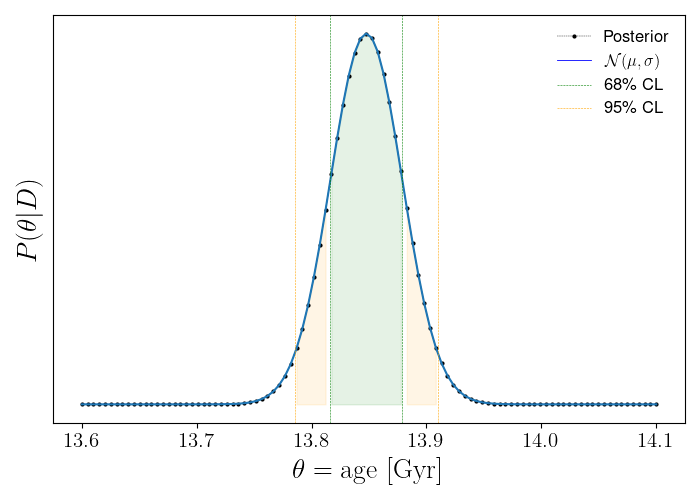

In [172]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='--',lw=0.3,markersize= 2.,label='Posterior')
plt.plot(u_age_x,y_fit,label=r'$\mathcal{N}(\mu,\sigma)$',c='b',lw=0.6)


plt.plot(u_age_x,gaussian_pdf*fit_params[0])
# Plot confidence intervals


plt.axvline(sigma_1_interval[0],ymin = 0,ymax = 1, color='green',  linestyle='--',lw=0.4, label='68\% CL')
plt.axvline(sigma_1_interval[1],ymin = 0,ymax = 1, color='green', linestyle='--',lw=0.4)

plt.axvline(sigma_2_interval[0], ymax = 1., color='orange',lw=0.4, linestyle='--', label='95\% CL')
plt.axvline(sigma_2_interval[1], ymax = 1., color='orange',lw=0.4, linestyle='--')

plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],
                 fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],color='green',alpha=0.1)

plt.fill_between(u_age_x[(u_age_x<sigma_1_interval[0]) & (u_age_x>sigma_2_interval[0])],
                 fit_params[0]*gaussian_pdf[(u_age_x<sigma_1_interval[0]) & (u_age_x>sigma_2_interval[0])],color='orange',alpha=0.1)

plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[1]) & (u_age_x<sigma_2_interval[1])],
                 fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[1]) & (u_age_x<sigma_2_interval[1])],color='orange',alpha=0.1)
# plt.title('Normal Distribution with Confidence Intervals')
# plt.xlabel('Value')
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)

# plt.ylabel('Probability Density')
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()

plt.savefig('posterior_only_age_plus_gauss_1s_2s.png',dpi=300)
plt.savefig('posterior_only_age_plus_gauss_1s_2s.pdf')


##### Wide Gaussian prior

In [173]:
from scipy.optimize import curve_fit
# Define the Gaussian (normal) distribution function
def gaussian(x,  amplitude, mean, stddev):
    return amplitude/(np.sqrt(2.*np.pi*stddev**2)) * np.exp(-((x - mean) / stddev) ** 2 / 2)

fit_params_wide, covariance = curve_fit(gaussian, u_age_x, u_age_pdf_wide*lkl_age, p0=[1e-23, 15.,2.])



In [174]:
fit_params_wide

array([8.47392286e-23, 1.38456648e+01, 3.05792254e-02])

In [175]:
y_fit = gaussian(u_age_x, *fit_params_wide)

In [176]:
# y_fit

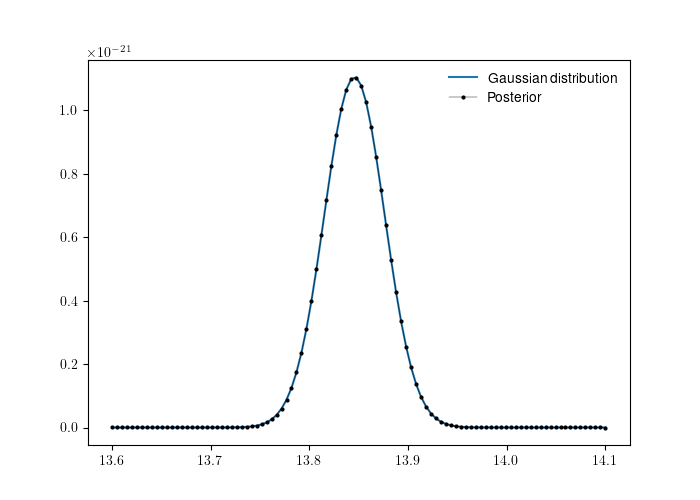

In [177]:
fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(u_age_x,y_fit,label='Gaussian distribution')
plt.plot(u_age_x,u_age_pdf_wide*lkl_age,marker='o',c='k',ls='-',lw=0.3,markersize= 2.,label='Posterior')
plt.legend(frameon=False)
plt.show()

In [178]:
gaussian_pdf_wide = norm.pdf(u_age_x, loc=fit_params_wide[1], scale=np.abs(fit_params_wide[2]))

In [179]:
sigma_1_interval_wide = fit_params_wide[1] + np.array([-1, 1]) * np.abs(fit_params_wide[2])
sigma_1_interval_wide

array([13.8150856 , 13.87624405])

In [180]:
sigma_2_interval_wide = fit_params_wide[1] + np.array([-2, 2]) * np.abs(fit_params_wide[2])
sigma_2_interval_wide

array([13.78450637, 13.90682327])

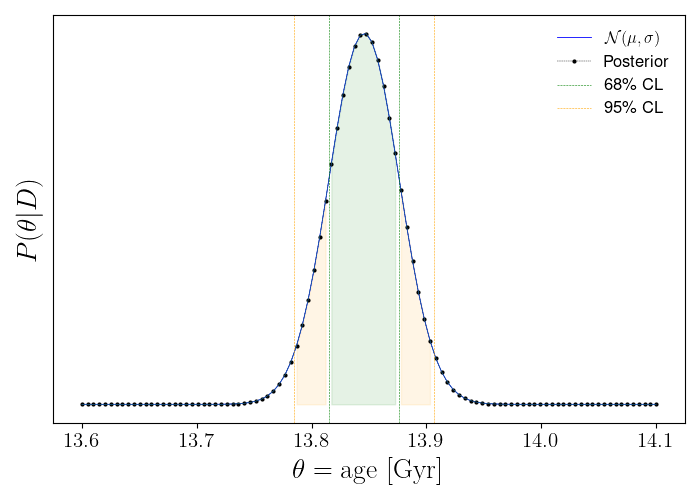

In [182]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,y_fit,label=r'$\mathcal{N}(\mu,\sigma)$',c='b',lw=0.6)
plt.plot(u_age_x,u_age_pdf_wide*lkl_age,marker='o',c='k',ls='--',lw=0.3,markersize= 2.,label='Posterior')

plt.plot(u_age_x,gaussian_pdf_wide*fit_params_wide[0],lw=0.4)
# Plot confidence intervals


plt.axvline(sigma_1_interval_wide[0],ymin = 0,ymax = 1, color='green',  linestyle='--',lw=0.4, label='68\% CL')
plt.axvline(sigma_1_interval_wide[1],ymin = 0,ymax = 1, color='green', linestyle='--',lw=0.4)

plt.axvline(sigma_2_interval_wide[0], ymax = 1., color='orange',lw=0.4, linestyle='--', label='95\% CL')
plt.axvline(sigma_2_interval_wide[1], ymax = 1., color='orange',lw=0.4, linestyle='--')

plt.fill_between(u_age_x[(u_age_x>sigma_1_interval_wide[0]) & (u_age_x<sigma_1_interval_wide[1])],
                 fit_params_wide[0]*gaussian_pdf_wide[(u_age_x>sigma_1_interval_wide[0]) & (u_age_x<sigma_1_interval_wide[1])],color='green',alpha=0.1)

plt.fill_between(u_age_x[(u_age_x<sigma_1_interval_wide[0]) & (u_age_x>sigma_2_interval_wide[0])],
                 fit_params_wide[0]*gaussian_pdf_wide[(u_age_x<sigma_1_interval_wide[0]) & (u_age_x>sigma_2_interval_wide[0])],color='orange',alpha=0.1)

plt.fill_between(u_age_x[(u_age_x>sigma_1_interval_wide[1]) & (u_age_x<sigma_2_interval_wide[1])],
                 fit_params_wide[0]*gaussian_pdf_wide[(u_age_x>sigma_1_interval_wide[1]) & (u_age_x<sigma_2_interval_wide[1])],color='orange',alpha=0.1)
# plt.title('Normal Distribution with Confidence Intervals')
# plt.xlabel('Value')
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)

# plt.ylabel('Probability Density')
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()
plt.show()


Analytical estimate


We can compute the mean and standard deviation of the posterior analytically in this case:





In [183]:
m1 = fit_params[1]
m2 = 13.8
s1 = fit_params[2]
s2 = wide_scale
mu = (m1/s1**2 + m2/s2**2)/(1./s1**2+1./s2**2)
s = 1./np.sqrt(1./s1**2+1./s2**2) 

In [184]:
mu

13.845663547514786

In [185]:
s

0.030574579688777272

In [186]:
fit_params_wide[2]

0.03057922537986788

In [187]:
fit_params_wide[1]

13.845664821098824

In [188]:
m1

13.84764296429599

In [189]:
s1

0.03123022110514296

In [190]:
gaussian_pdf_analytical = norm.pdf(u_age_x, loc=mu, scale=s)

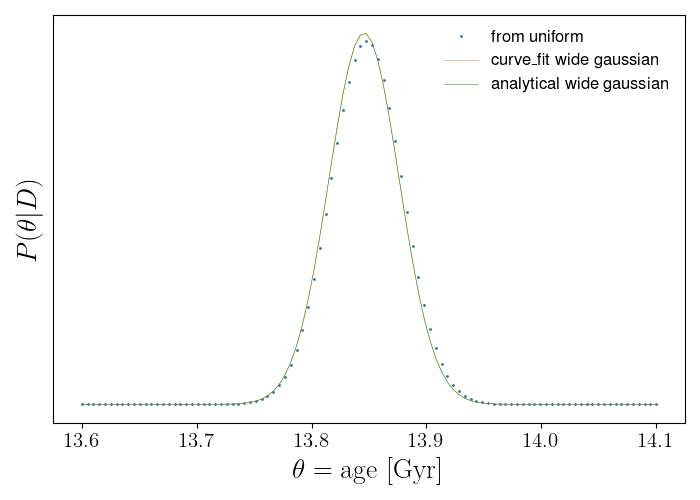

In [192]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,gaussian_pdf,lw=0.4,label='from uniform',marker='o',markersize=1.,ls='None')
plt.plot(u_age_x,gaussian_pdf_wide,lw=0.4,label='curve_fit wide gaussian')
plt.plot(u_age_x,gaussian_pdf_analytical,lw=0.4,label='analytical wide gaussian')
# plt.title('Normal Distribution with Confidence Intervals')
# plt.xlabel('Value')
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)

# plt.ylabel('Probability Density')
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()
plt.show()


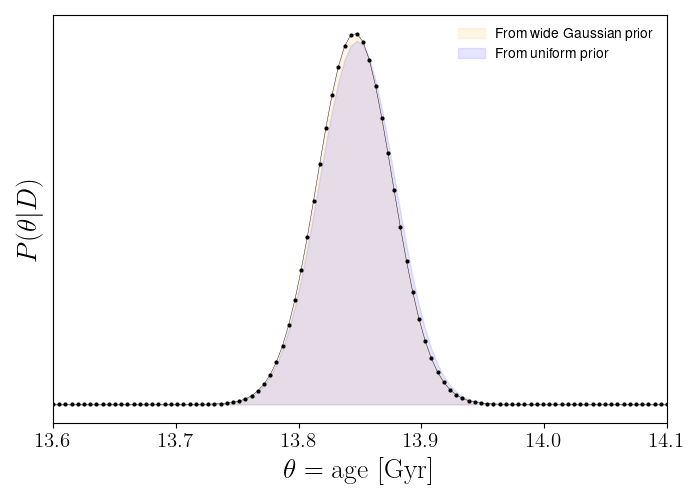

In [194]:
from scipy.stats import norm
fig, ax  = plt.subplots(figsize=(7,5))


plt.plot(u_age_x,u_age_pdf_wide*lkl_age/fit_params_wide[0],marker='o',c='k',ls='-',lw=0.3,markersize= 2)

plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)

plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
# plt.grid(which='both',alpha=0.3)
plt.xlim(13.6,14.1)
plt.fill_between(u_age_x,u_age_pdf_wide*lkl_age/fit_params_wide[0],color='orange',alpha=0.1,label='From wide Gaussian prior')

plt.fill_between(u_age_x,u_age_pdf*lkl_age/fit_params[0],color='blue',alpha=0.1,label='From uniform prior')

plt.legend(frameon=False)
fig.tight_layout()

plt.savefig("posterior_age_wg_compare.pdf")
plt.savefig("posterior_age_wg_compare.png",dpi=300)